# Market Regime Detection using Hidden Markov Models (HMMs). This implementation includes:

✅ Fetching historical stock/index data (e.g., S&P 500, NASDAQ, Crypto)  
✅ Feature Engineering: Returns, volatility, moving averages  
✅ Training a Gaussian Hidden Markov Model (HMM)  
✅ Predicting market regimes (Bull, Bear, Neutral)  
✅ Multiple Visualizations:
- Market regime overlay on stock prices 📈  
- Probability distribution of regimes 🎯  
- Transition probability heatmap 🔥  
- Returns distribution per regime 🏦  

## Install Required Libraries
We will use `hmmlearn` for Hidden Markov Models and standard libraries for data processing & visualization.

In [20]:
!pip install yfinance pandas numpy matplotlib seaborn scikit-learn hmmlearn

## Import Libraries
These include:
- `yfinance` for stock data
- `pandas & numpy` for data manipulation
- `hmmlearn` for Hidden Markov Models
- `matplotlib & seaborn` for visualizations


In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

## Fetch Historical Stock Data
We will analyze **S&P 500 (SPY ETF)** from 2010 to the present.


In [22]:
# Fetch stock data
ticker = "SPY"  # S&P 500 ETF
start_date = "2010-01-01"
end_date = "2025-03-01"

df = yf.download(ticker, start=start_date, end=end_date)
df["Returns"] = df["Close"].pct_change()
df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
df = df.dropna()
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Returns,Log Returns
Ticker,SPY,SPY,SPY,SPY,SPY,,
Date,,,,,,,
2010-01-05,86.254204,86.292160,85.662123,85.973348,111579900,0.002648,0.002644
2010-01-06,86.314896,86.527437,86.102354,86.170669,116074400,0.000704,0.000703
2010-01-07,86.679298,86.785569,85.912626,86.155532,131091100,0.004222,0.004213
2010-01-08,86.967697,87.005653,86.276938,86.451523,126402800,0.003327,0.003322
2010-01-11,87.089157,87.392784,86.717204,87.354834,106375700,0.001397,0.001396


## Feature Engineering
We will compute:
- **Log Returns**
- **Volatility (Rolling Std Dev)**
- **Moving Averages**
- **Momentum**


In [23]:
# Compute volatility (rolling standard deviation)
df["Volatility"] = df["Log Returns"].rolling(window=30).std()

# Compute moving averages
df["MA_30"] = df["Close"].rolling(window=30).mean()
df["MA_100"] = df["Close"].rolling(window=100).mean()

# Compute momentum
df["Momentum"] = df["Close"] - df["Close"].shift(10)

# Drop NaN values
df = df.dropna()

## Train a Hidden Markov Model (HMM)
- We use **3 regimes** (Bull, Bear, Neutral).
- The model is trained on **Log Returns & Volatility**.
- The HMM will learn **hidden market states**.


In [24]:
# Select features for HMM
features = df[["Log Returns", "Volatility"]].values
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Train HMM
n_states = 3  # Bull, Bear, Neutral
hmm = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=200)
hmm.fit(features_scaled)

# Predict hidden states (market regimes)
df["Regime"] = hmm.predict(features_scaled)

## Market Regime Visualization
✅ **Overlay regimes on stock prices**  
✅ **Plot regime probability distributions**  
✅ **Analyze regime transition probabilities**  
✅ **Show returns distribution per regime**  


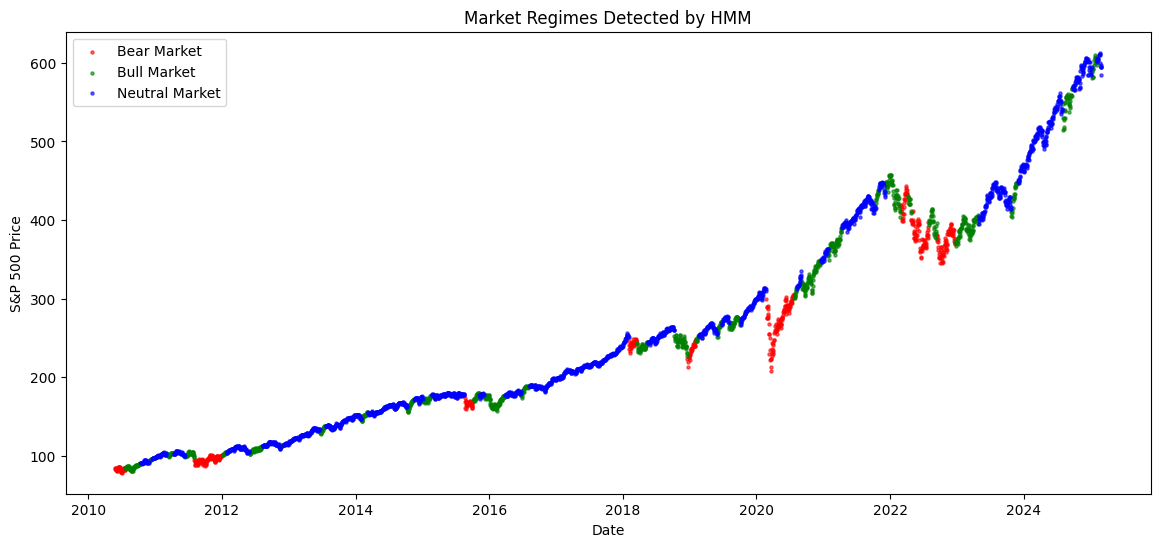

In [25]:
#@title Overlay Market Regimes on Stock Prices
plt.figure(figsize=(14, 6))
colors = ["red", "blue", "green"]
regime_names = ["Bear Market", "Neutral Market", "Bull Market"]

for i, regime in enumerate(df["Regime"].unique()):
    plt.scatter(df.index[df["Regime"] == regime],
                df["Close"][df["Regime"] == regime],
                label=regime_names[regime],
                color=colors[regime],
                alpha=0.6, s=5)

plt.title("Market Regimes Detected by HMM")
plt.xlabel("Date")
plt.ylabel("S&P 500 Price")
plt.legend()
plt.show()

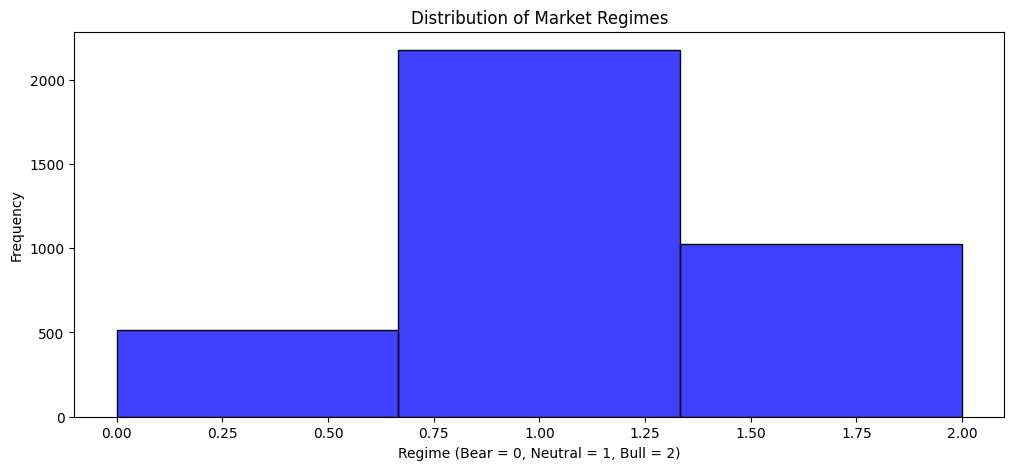

In [26]:
#@title Regime Probability Distribution
plt.figure(figsize=(12, 5))
sns.histplot(df["Regime"], bins=n_states, kde=False, color="blue")
plt.title("Distribution of Market Regimes")
plt.xlabel("Regime (Bear = 0, Neutral = 1, Bull = 2)")
plt.ylabel("Frequency")
plt.show()

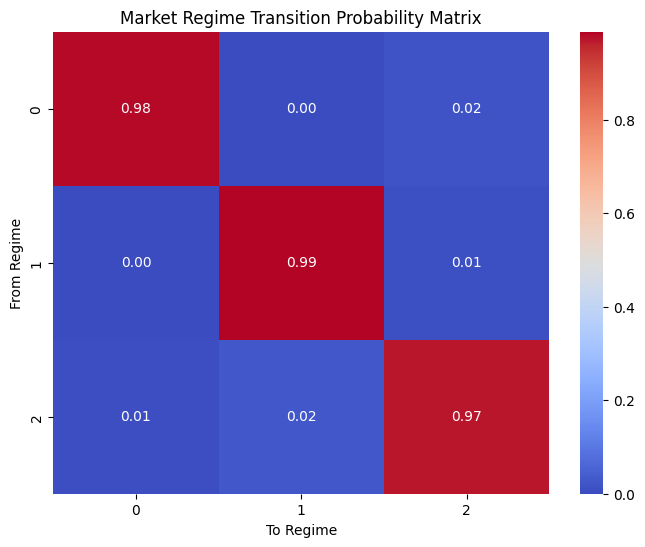

In [27]:
#@title Transition Probability Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(hmm.transmat_, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Market Regime Transition Probability Matrix")
plt.xlabel("To Regime")
plt.ylabel("From Regime")
plt.show()

<ipython-input-28-338e9d2d69cf>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=df["Regime"], y=df["Log Returns"], palette=["red", "blue", "green"])


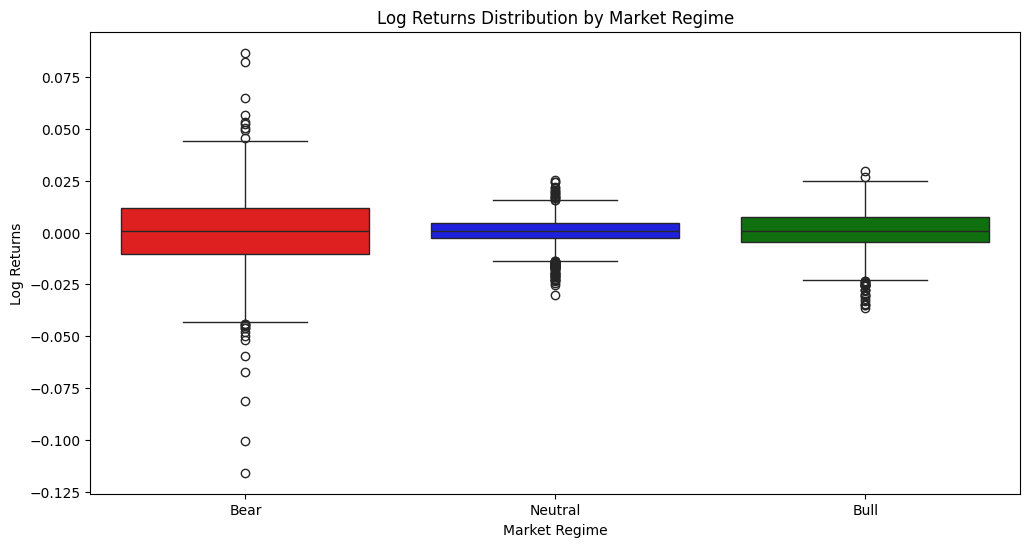

In [28]:
#@title Returns Distribution per Regime
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["Regime"], y=df["Log Returns"], palette=["red", "blue", "green"])
plt.title("Log Returns Distribution by Market Regime")
plt.xlabel("Market Regime")
plt.ylabel("Log Returns")
plt.xticks(ticks=[0, 1, 2], labels=["Bear", "Neutral", "Bull"])
plt.show()

## Trading Strategy Based on Market Regimes
- **Bull Market (Green):** Go **Long**.
- **Bear Market (Red):** Go **Short**.
- **Neutral Market (Yellow):** Hold cash.


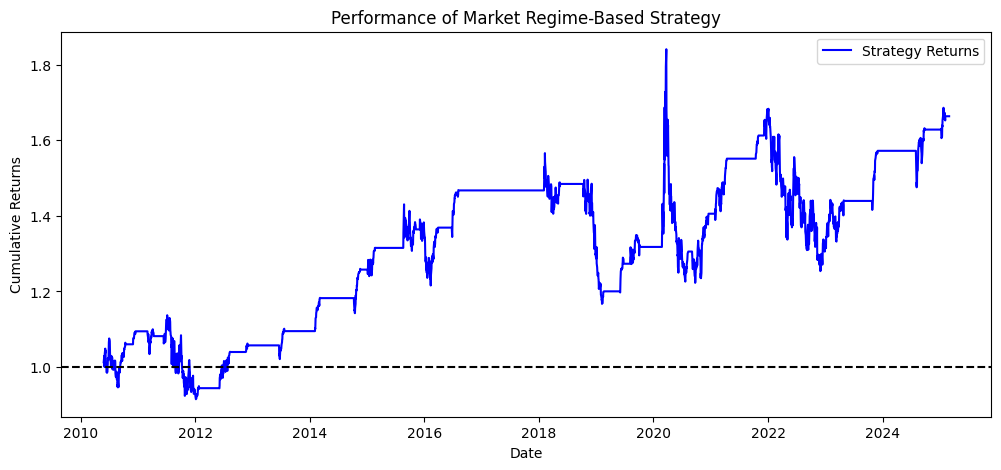

In [29]:
df["Strategy"] = 0
df.loc[df["Regime"] == 2, "Strategy"] = 1   # Bull → Long
df.loc[df["Regime"] == 0, "Strategy"] = -1  # Bear → Short

df["Strategy Returns"] = df["Strategy"].shift(1) * df["Log Returns"]
df["Cumulative Returns"] = (1 + df["Strategy Returns"]).cumprod()

plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Cumulative Returns"], label="Strategy Returns", color="blue")
plt.axhline(1, linestyle="--", color="black")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.title("Performance of Market Regime-Based Strategy")
plt.show()


# MarketRegimeHMM: Python OOP class for HMM
It will do the followinng:  
- **Analyze multiple indices (S&P 500, NASDAQ, Dow Jones, etc.)**  
- **Fetch data, process it, and train models dynamically.**  
- **Generate visualizations per index.**  
- **Allow easy modifications for live deployment and strategy optimization.**  

## MarketRegimeHMM class implementation

In [30]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

class MarketRegimeHMM:
    def __init__(self, ticker, start_date="2010-01-01", end_date="2025-03-01", n_states=3):
        """
        Initialize with the stock/index ticker, date range, and number of HMM states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.hmm = None
        self.features_scaled = None

    def fetch_data(self):
        """
        Fetch historical market data from Yahoo Finance and calculate returns & volatility.
        """
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        df["Returns"] = df["Close"].pct_change()
        df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
        df["Volatility"] = df["Log Returns"].rolling(window=30).std()
        df["Momentum"] = df["Close"] - df["Close"].shift(10)
        df["MA_30"] = df["Close"].rolling(window=30).mean()
        df["MA_100"] = df["Close"].rolling(window=100).mean()
        self.df = df.dropna()
        return self.df

    def train_hmm(self):
        """
        Train a Gaussian Hidden Markov Model (HMM) with the market data.
        """
        features = self.df[["Log Returns", "Volatility"]].values
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(features)

        self.hmm = GaussianHMM(n_components=self.n_states, covariance_type="full", n_iter=200)
        self.hmm.fit(self.features_scaled)

        self.df["Regime"] = self.hmm.predict(self.features_scaled)

    def visualize_market_regimes(self):
        """
        Visualize Market Regimes on the stock price.
        """
        plt.figure(figsize=(14, 6))
        colors = ["red", "blue", "green"]
        regime_names = ["Bear Market", "Neutral Market", "Bull Market"]

        for i, regime in enumerate(self.df["Regime"].unique()):
            plt.scatter(self.df.index[self.df["Regime"] == regime],
                        self.df["Close"][self.df["Regime"] == regime],
                        label=regime_names[regime],
                        color=colors[regime],
                        alpha=0.6, s=5)

        plt.title(f"Market Regimes Detected by HMM for {self.ticker}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_transition_probabilities(self):
        """
        Plot the heatmap of market regime transition probabilities.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.hmm.transmat_, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Market Regime Transition Probabilities for {self.ticker}")
        plt.xlabel("To Regime")
        plt.ylabel("From Regime")
        plt.show()

    def backtest_strategy(self):
        """
        Backtest a simple trading strategy based on detected market regimes.
        - Bull Market → Go long
        - Bear Market → Short
        - Neutral Market → Hold Cash
        """
        self.df["Strategy"] = 0
        self.df.loc[self.df["Regime"] == 2, "Strategy"] = 1  # Bull → Long
        self.df.loc[self.df["Regime"] == 0, "Strategy"] = -1  # Bear → Short

        self.df["Strategy Returns"] = self.df["Strategy"].shift(1) * self.df["Log Returns"]
        self.df["Cumulative Returns"] = (1 + self.df["Strategy Returns"]).cumprod()

        plt.figure(figsize=(12, 5))
        plt.plot(self.df.index, self.df["Cumulative Returns"], label="Strategy Returns", color="blue")
        plt.axhline(1, linestyle="--", color="black")
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.title(f"Performance of Market Regime-Based Strategy for {self.ticker}")
        plt.show()

## Run the Model for Multiple Indices
    "S&P 500 ETF": "SPY",  
    "NASDAQ 100": "QQQ",  
    "NASDAQ Composite": "^IXIC",  
    "Dow Jones Industrial Average": "^DJI",  
    "NASDAQ AI Index": "ROBO",  
    "NASDAQ Semiconductor": "^SOX",  
    "NASDAQ Quantum Computing Index": "QTUM"  

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for S&P 500 ETF (SPY) ===



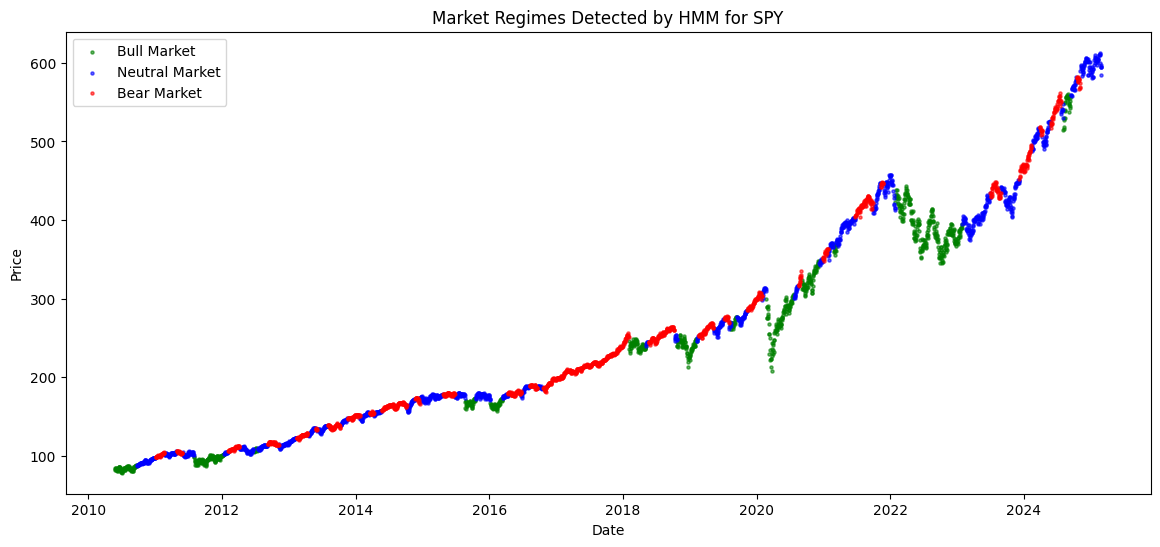

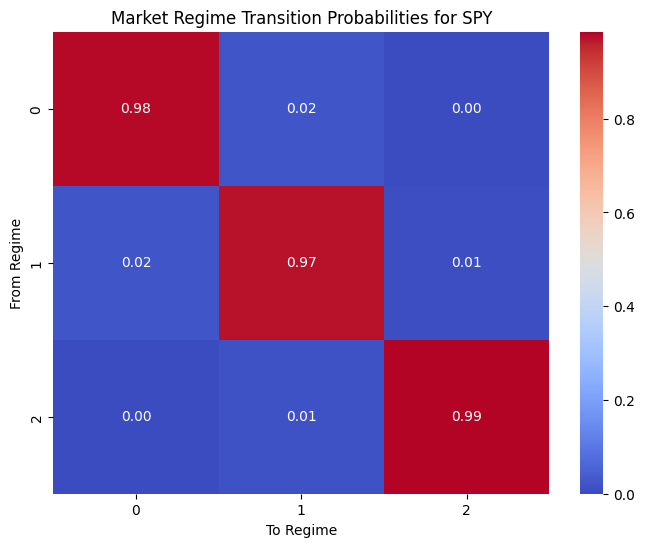

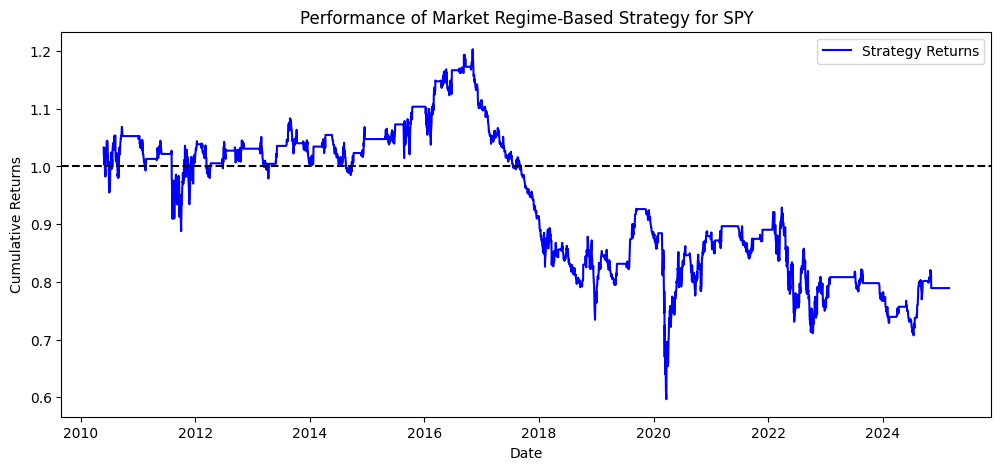

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ 100 (QQQ) ===



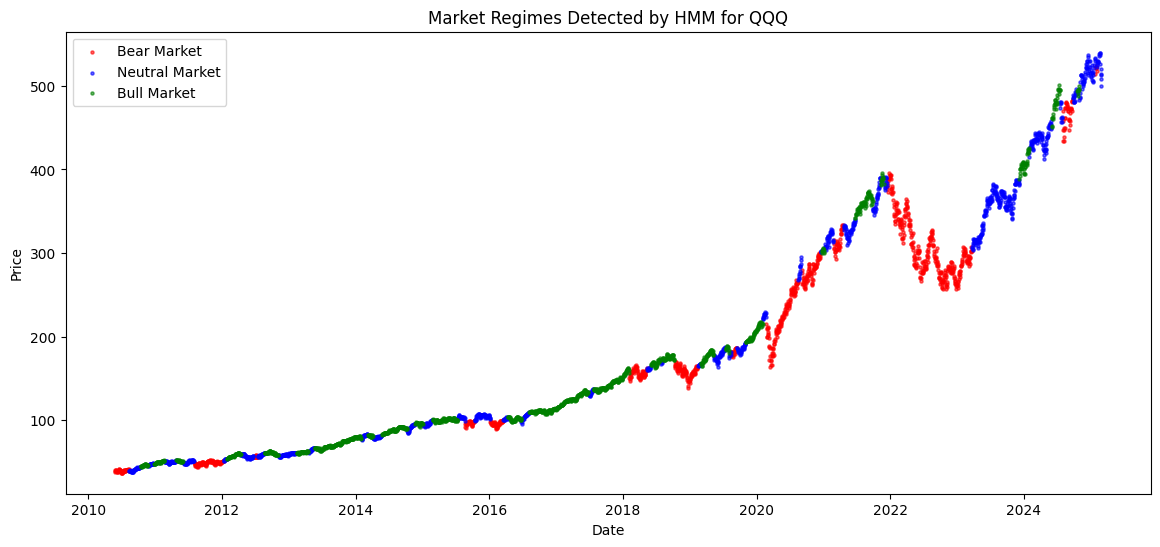

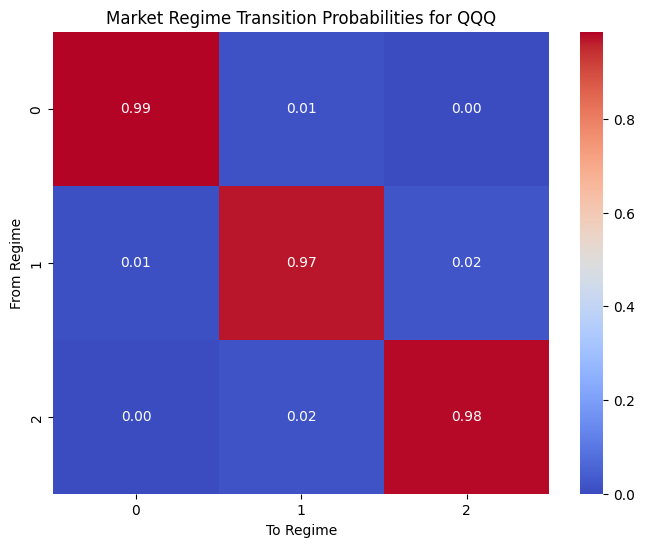

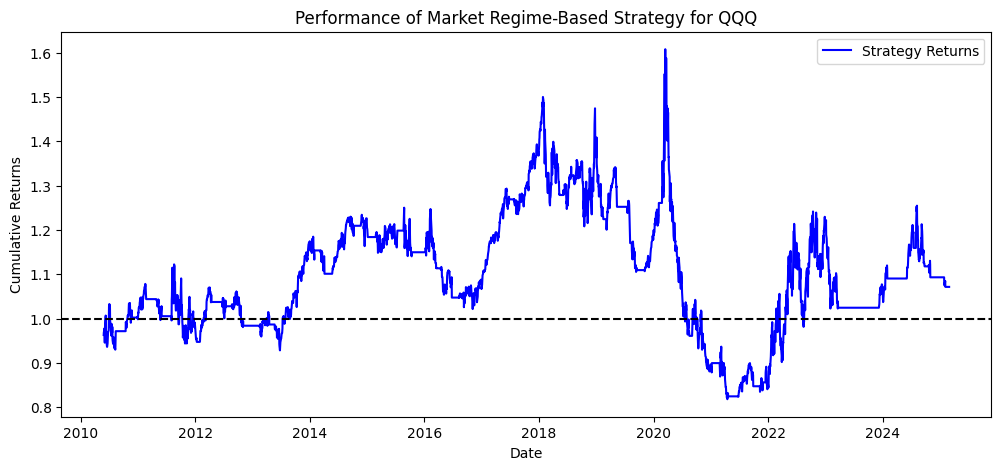

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Composite (^IXIC) ===



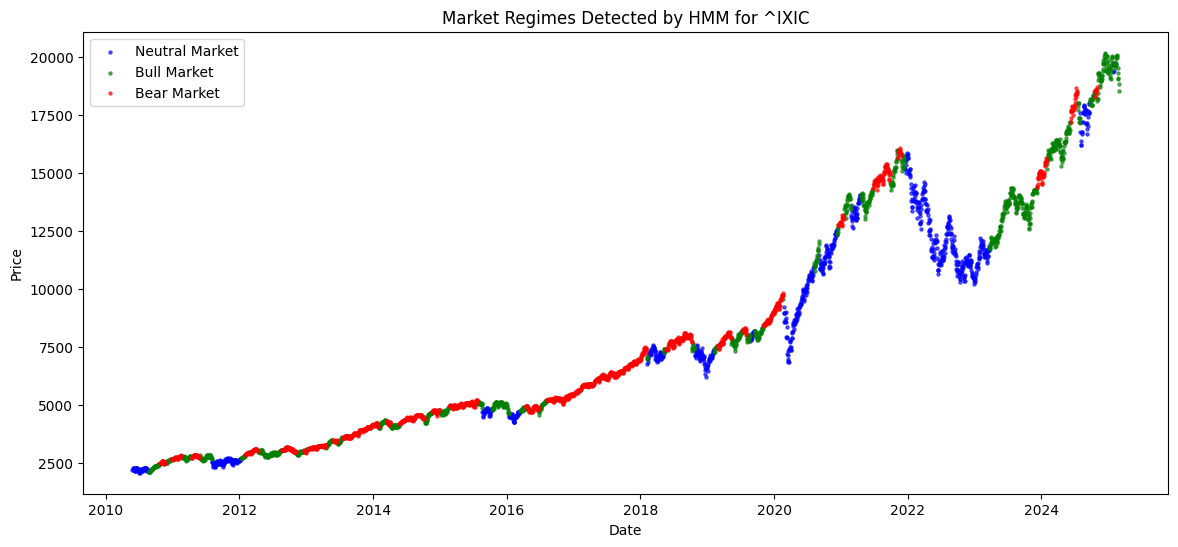

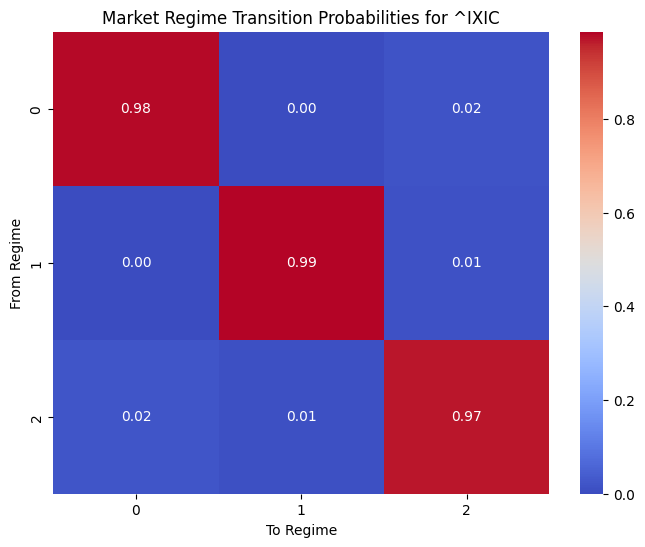

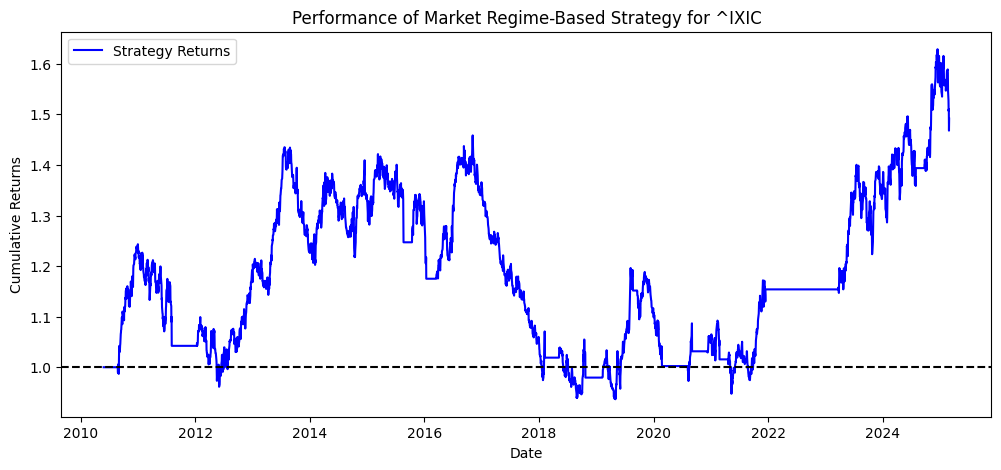

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for Dow Jones Industrial Average (^DJI) ===



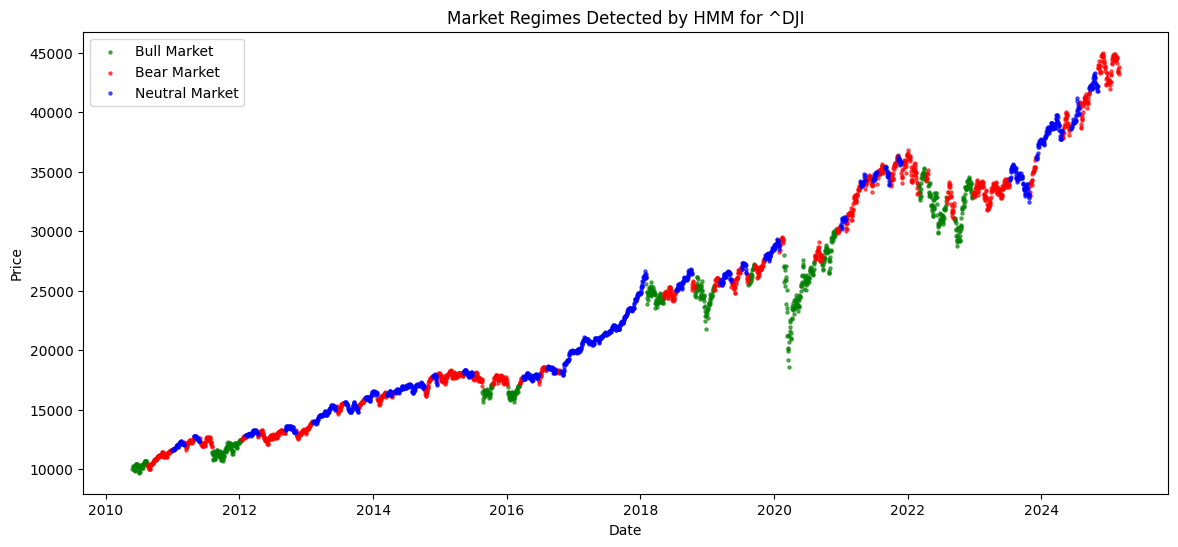

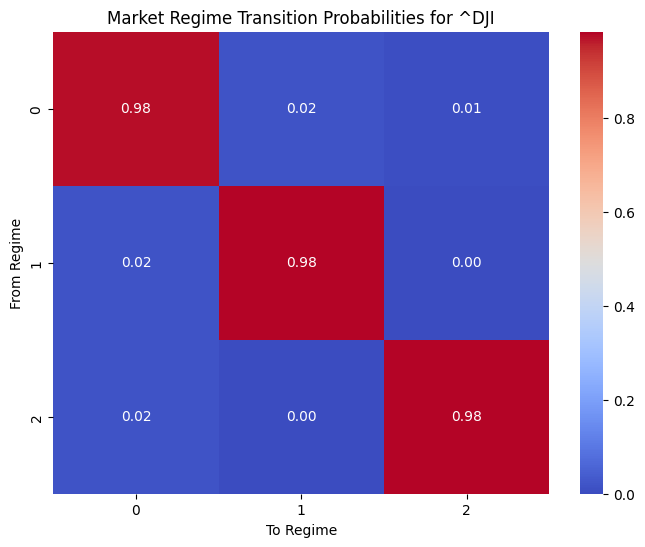

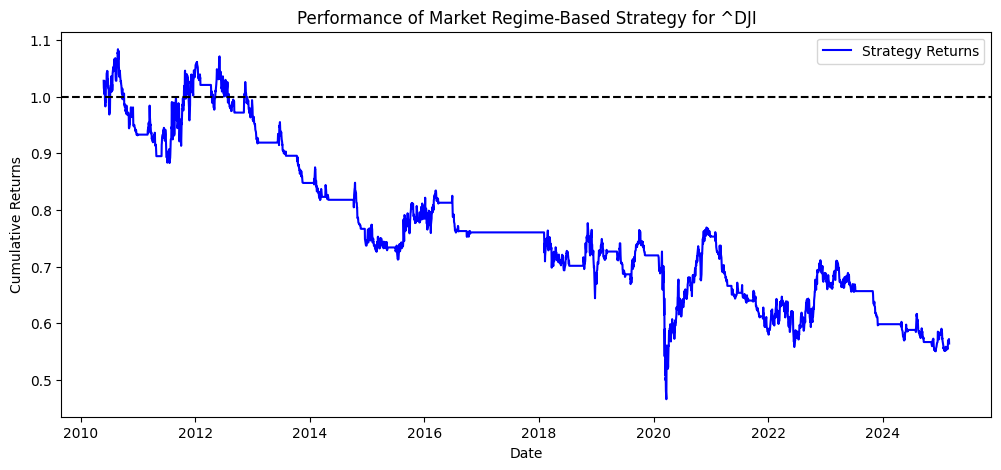

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ AI Index (ROBO) ===



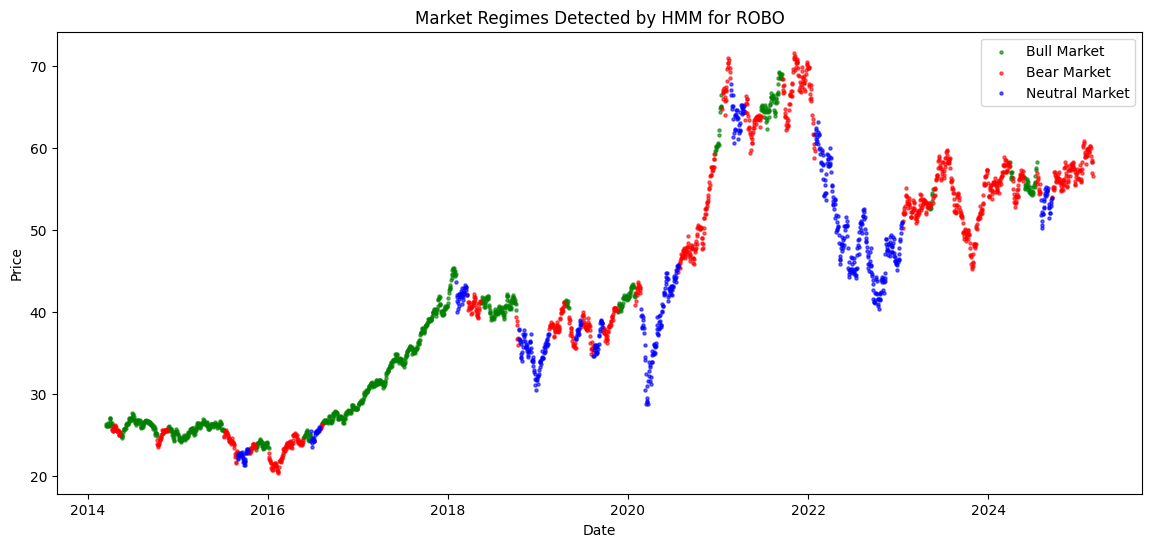

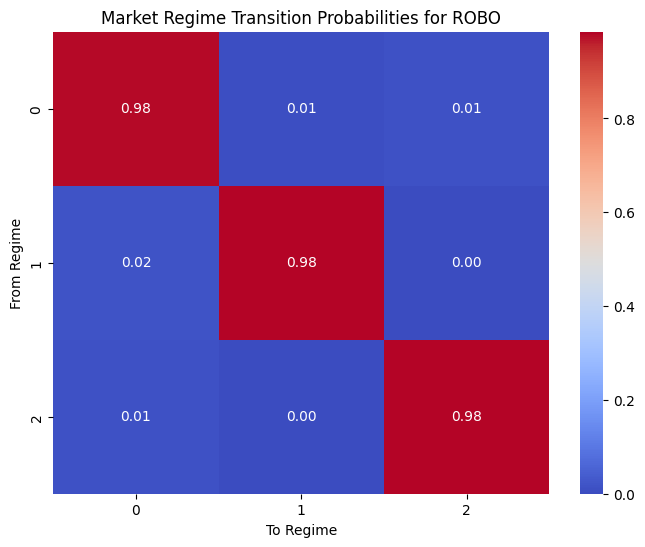

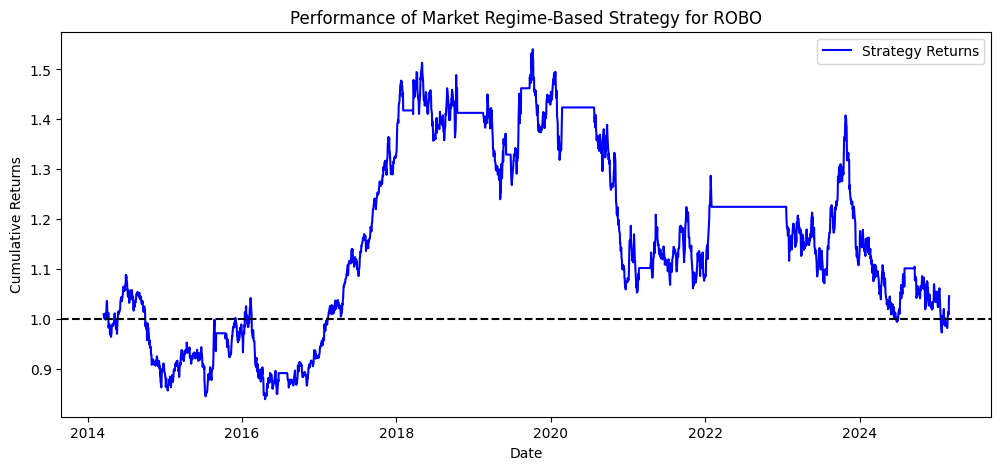

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Semiconductor (^SOX) ===



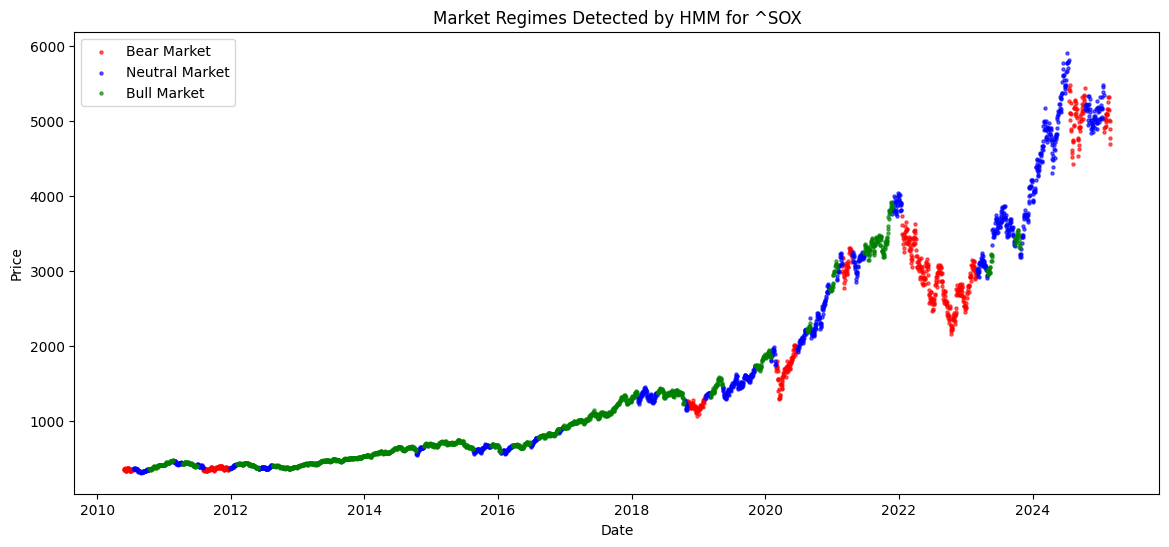

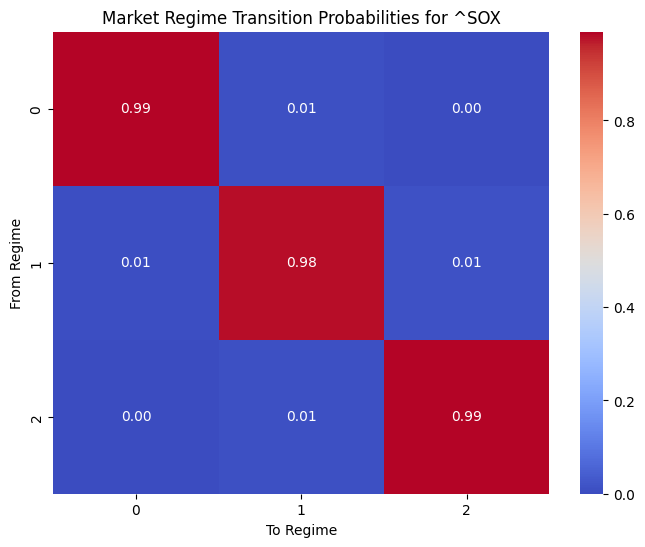

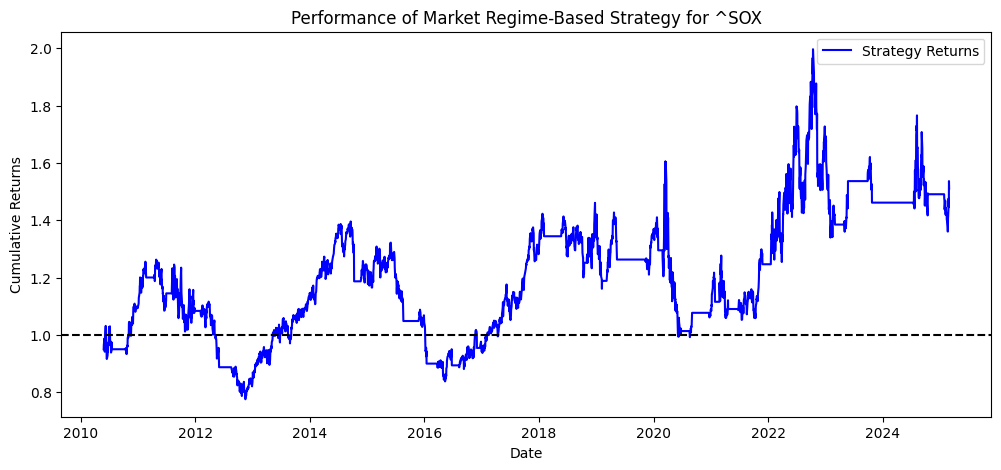

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Quantum Computing Index (QTUM) ===



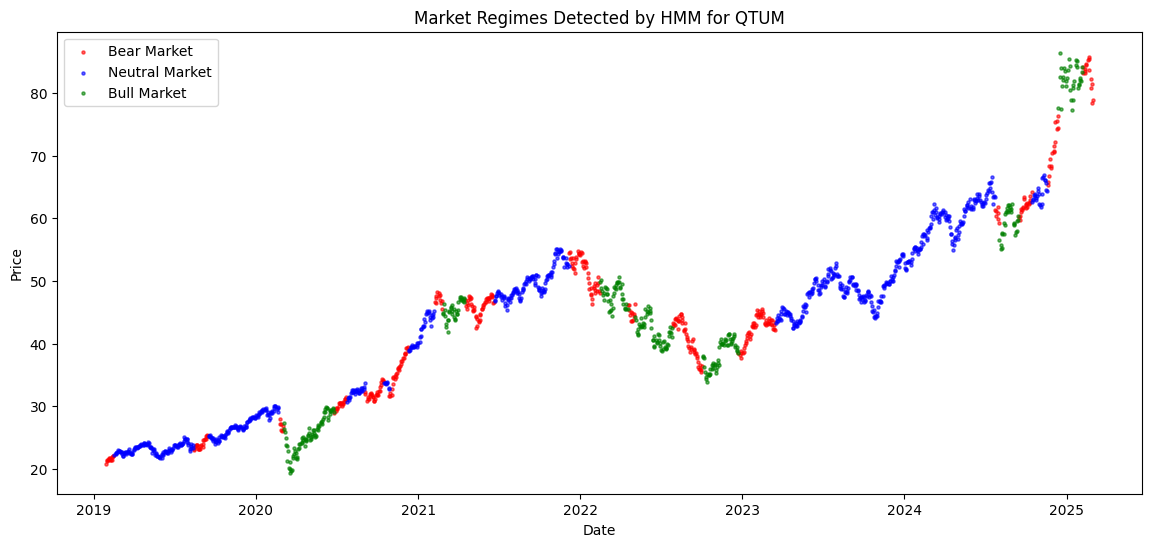

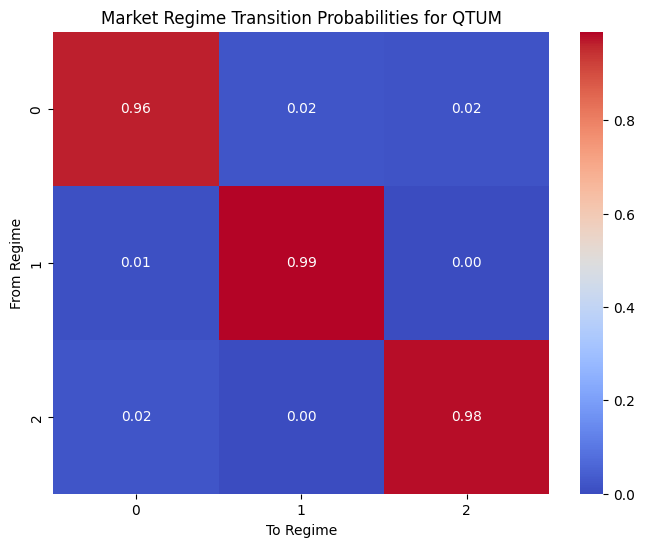

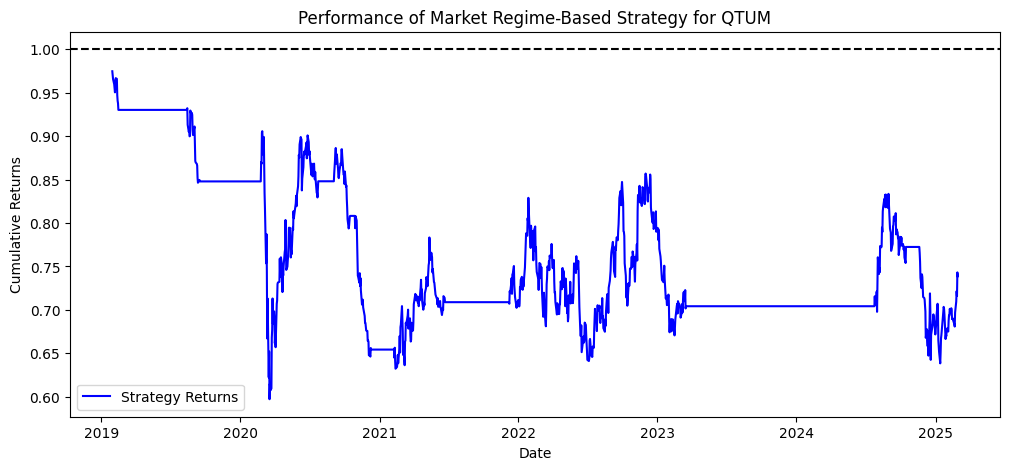

In [31]:
# List of major market indices
indices = {
    "S&P 500 ETF": "SPY",
    "NASDAQ 100": "QQQ",
    "NASDAQ Composite": "^IXIC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ AI Index": "ROBO",
    "NASDAQ Semiconductor": "^SOX",
    "NASDAQ Quantum Computing Index": "QTUM"
}

# Run the analysis for each index
for name, ticker in indices.items():
    print(f"\n=== Running Market Regime Detection for {name} ({ticker}) ===\n")

    model = MarketRegimeHMM(ticker)
    model.fetch_data()
    model.train_hmm()
    model.visualize_market_regimes()
    model.plot_transition_probabilities()
    model.backtest_strategy()

# Optimizing Trading Strategy with Stop-Loss & Leverage
We will now improve our Market Regime-Based Trading Strategy by adding:  
✅ Stop-Loss Mechanism – To cut losses and protect capital.  
✅ Leverage Adjustment – To scale position sizes based on regime confidence.  

## Update the Class with Stop-Loss & Leverage
We will modify the backtest strategy function in our MarketRegimeHMM class.

In [32]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler

class MarketRegimeHMM:
    def __init__(self, ticker, start_date="2010-01-01", end_date="2025-03-01", n_states=3):
        """
        Initialize with the stock/index ticker, date range, and number of HMM states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.hmm = None
        self.features_scaled = None

    def fetch_data(self):
        """
        Fetch historical market data from Yahoo Finance and calculate returns & volatility.
        """
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        df["Returns"] = df["Close"].pct_change()
        df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
        df["Volatility"] = df["Log Returns"].rolling(window=30).std()
        df["Momentum"] = df["Close"] - df["Close"].shift(10)
        df["MA_30"] = df["Close"].rolling(window=30).mean()
        df["MA_100"] = df["Close"].rolling(window=100).mean()
        self.df = df.dropna()
        return self.df

    def train_hmm(self):
        """
        Train a Gaussian Hidden Markov Model (HMM) with the market data.
        """
        features = self.df[["Log Returns", "Volatility"]].values
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(features)

        self.hmm = GaussianHMM(n_components=self.n_states, covariance_type="full", n_iter=200)
        self.hmm.fit(self.features_scaled)

        self.df["Regime"] = self.hmm.predict(self.features_scaled)

    def visualize_market_regimes(self):
        """
        Visualize Market Regimes on the stock price.
        """
        plt.figure(figsize=(14, 6))
        colors = ["red", "blue", "green"]
        regime_names = ["Bear Market", "Neutral Market", "Bull Market"]

        for i, regime in enumerate(self.df["Regime"].unique()):
            plt.scatter(self.df.index[self.df["Regime"] == regime],
                        self.df["Close"][self.df["Regime"] == regime],
                        label=regime_names[regime],
                        color=colors[regime],
                        alpha=0.6, s=5)

        plt.title(f"Market Regimes Detected by HMM for {self.ticker}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def plot_transition_probabilities(self):
        """
        Plot the heatmap of market regime transition probabilities.
        """
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.hmm.transmat_, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title(f"Market Regime Transition Probabilities for {self.ticker}")
        plt.xlabel("To Regime")
        plt.ylabel("From Regime")
        plt.show()

    def backtest_strategy(self, stop_loss_threshold=0.05, leverage_factor=1.5):
        """
        Backtest a trading strategy with stop-loss & leverage adjustment.
        - Bull Market → Go Long (Leverage Applied)
        - Bear Market → Go Short
        - Neutral Market → Reduce Exposure
        - Stop-loss applied when losses exceed a given threshold.
        """
        self.df["Strategy"] = 0
        self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage
        self.df.loc[self.df["Regime"] == 0, "Strategy"] = -1  # Bear → Short

        # Compute daily returns based on strategy
        self.df["Strategy Returns"] = self.df["Strategy"].shift(1) * self.df["Log Returns"]

        # Apply stop-loss: If daily loss exceeds threshold, close position
        self.df["Strategy Returns"] = np.where(self.df["Strategy Returns"] < -stop_loss_threshold, 0, self.df["Strategy Returns"])

        # Compute cumulative returns
        self.df["Cumulative Returns"] = (1 + self.df["Strategy Returns"]).cumprod()

        # Plot strategy performance
        plt.figure(figsize=(12, 5))
        plt.plot(self.df.index, self.df["Cumulative Returns"], label="Strategy Returns", color="blue")
        plt.axhline(1, linestyle="--", color="black")
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.title(f"Performance of Market Regime-Based Strategy for {self.ticker}")
        plt.show()

## Run the Model for Multiple Indices

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for S&P 500 ETF (SPY) ===



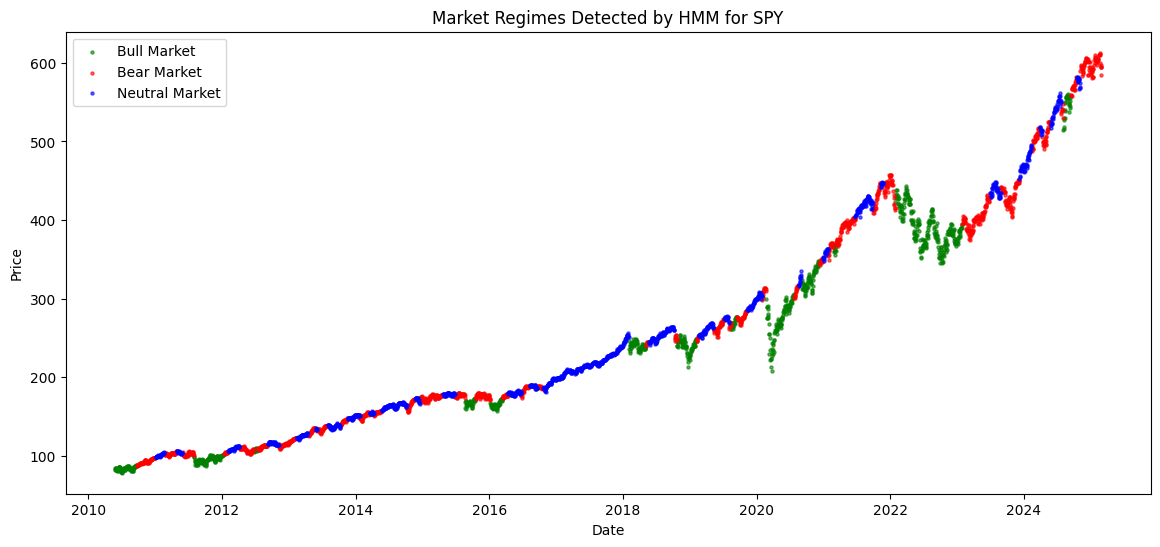

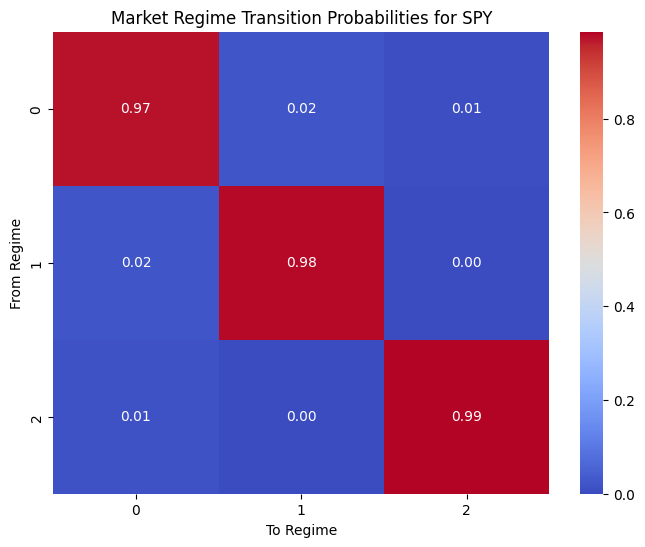

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


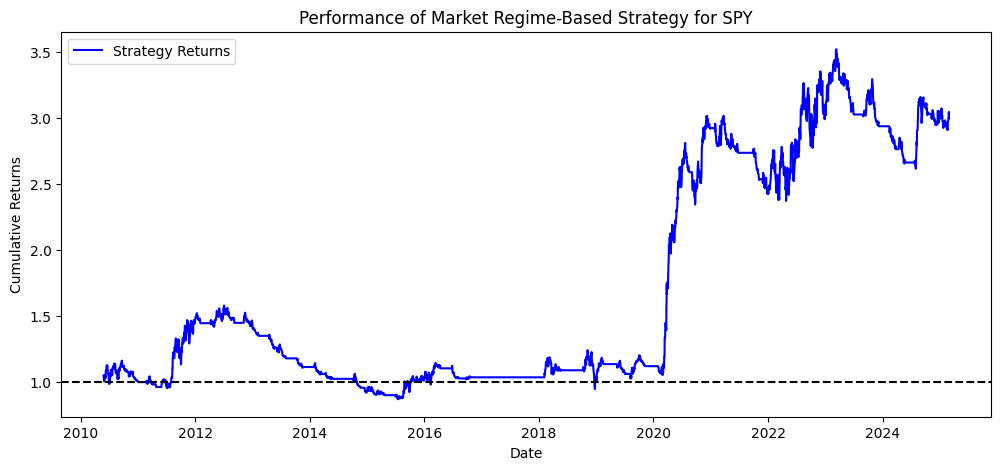

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ 100 (QQQ) ===



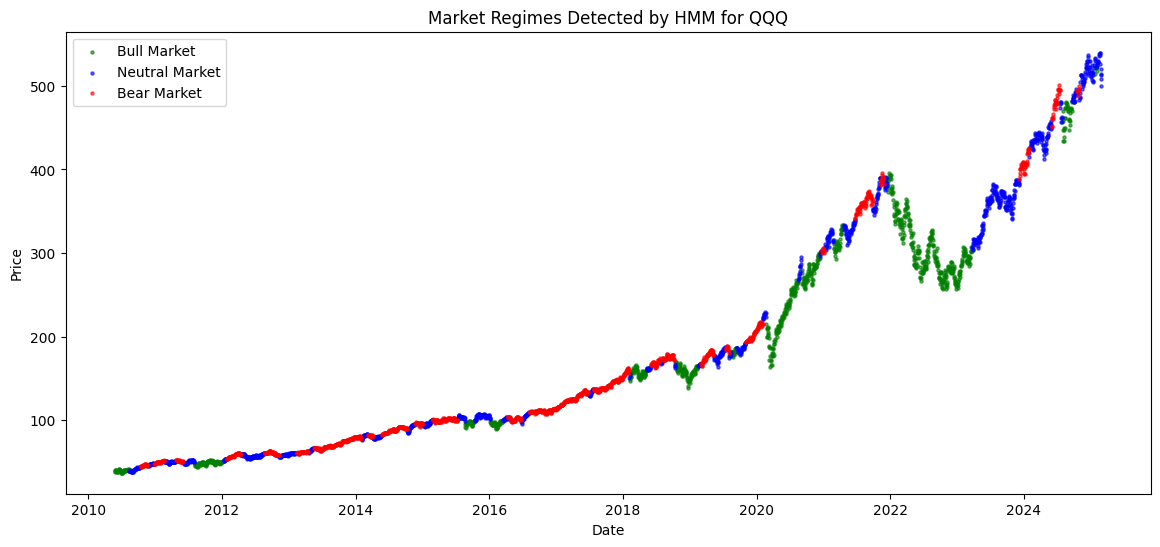

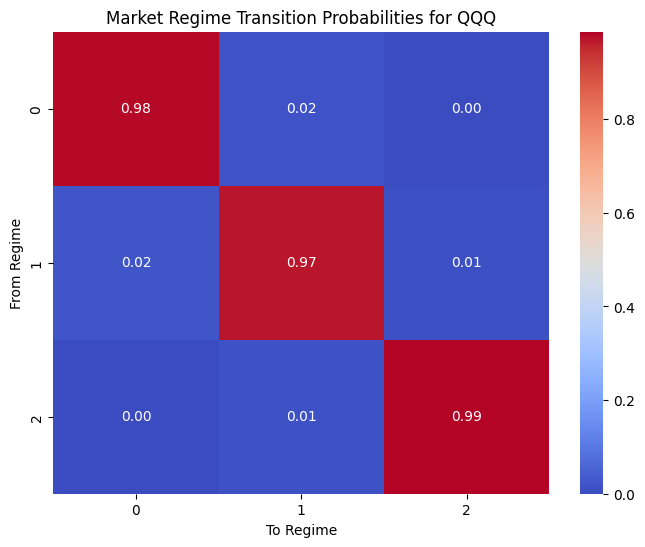

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


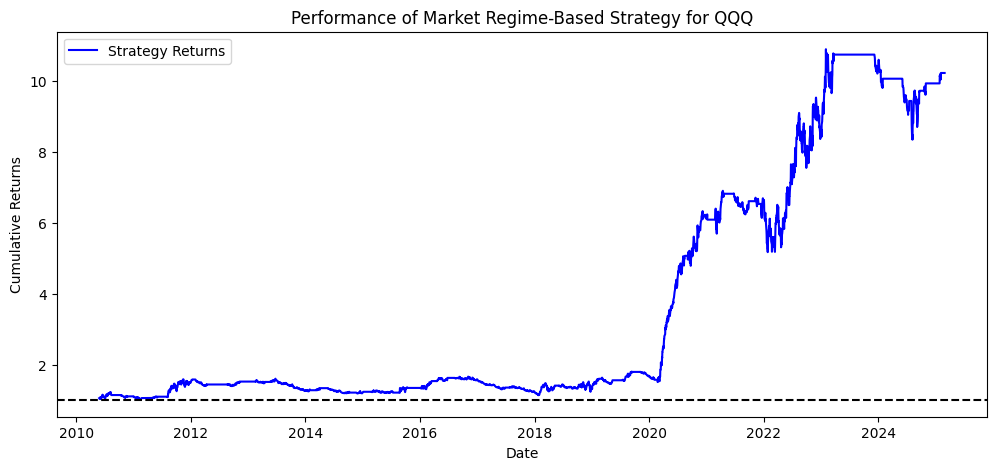

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Composite (^IXIC) ===



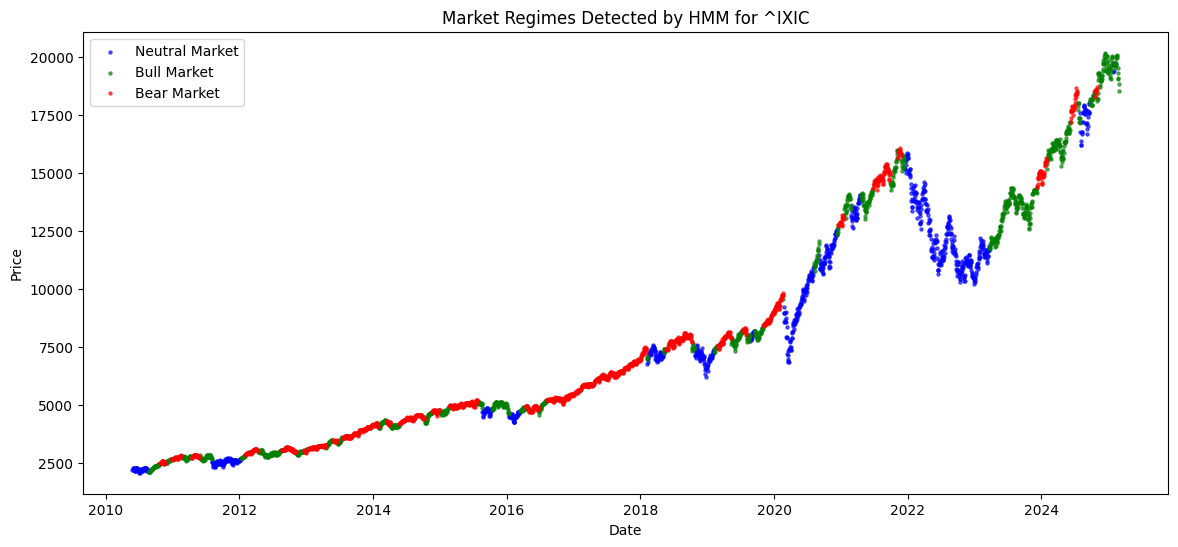

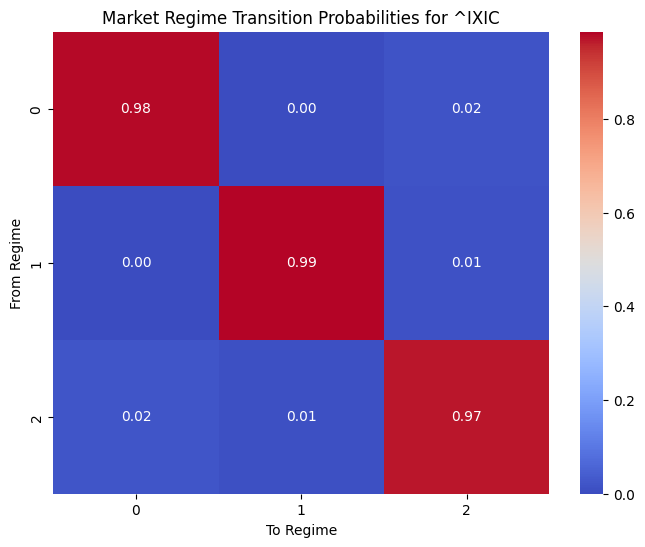

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


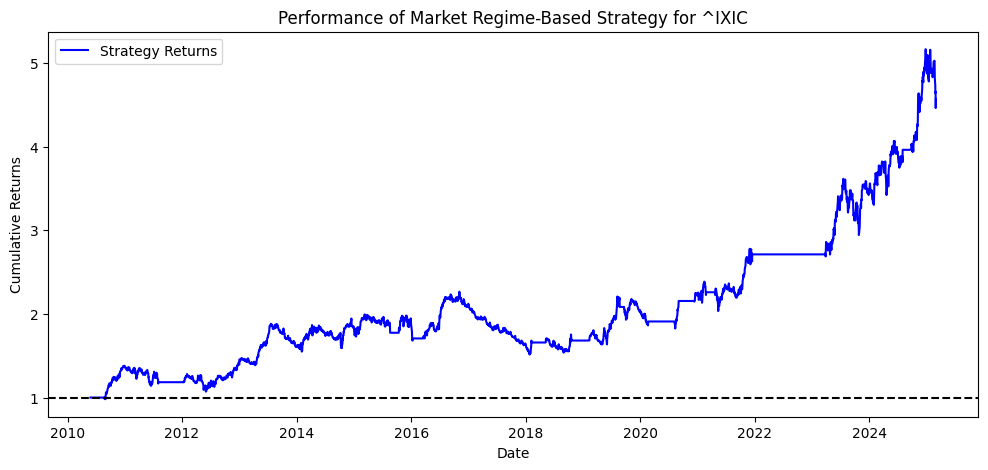

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for Dow Jones Industrial Average (^DJI) ===



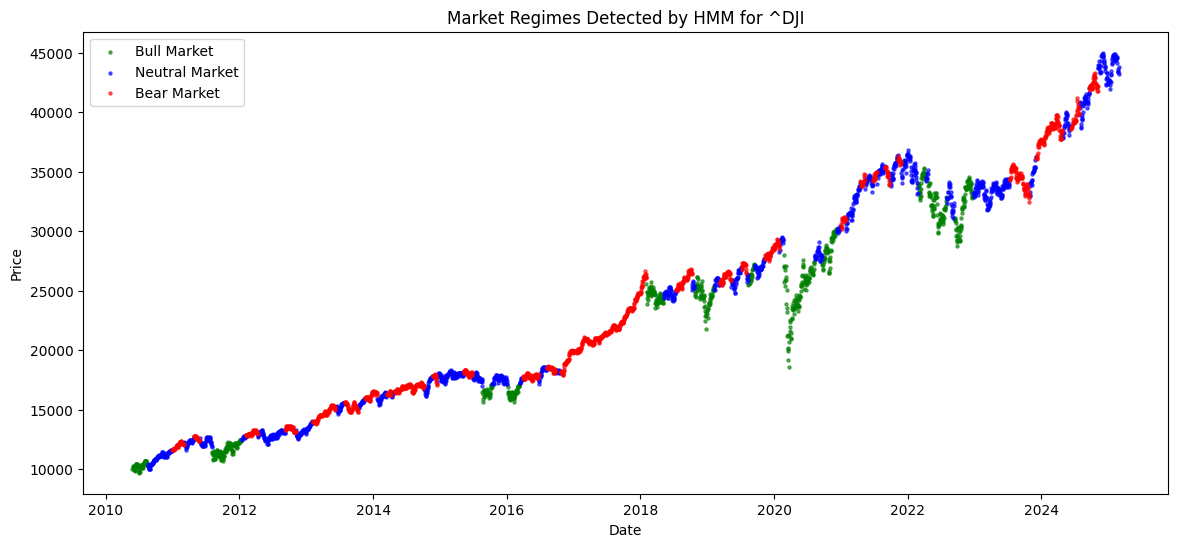

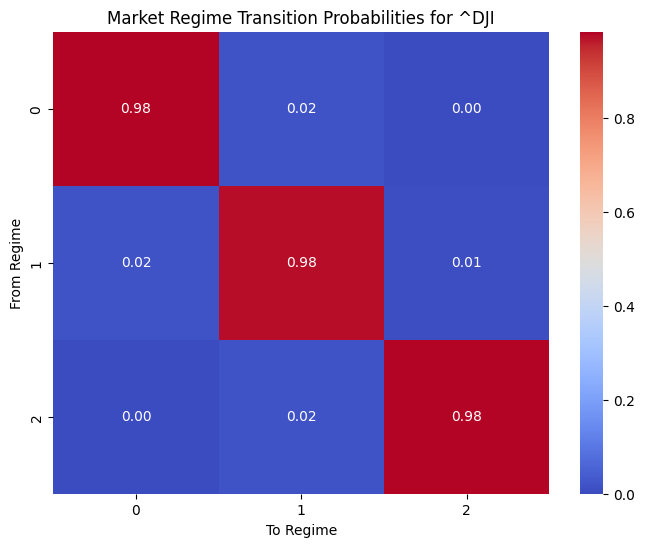

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


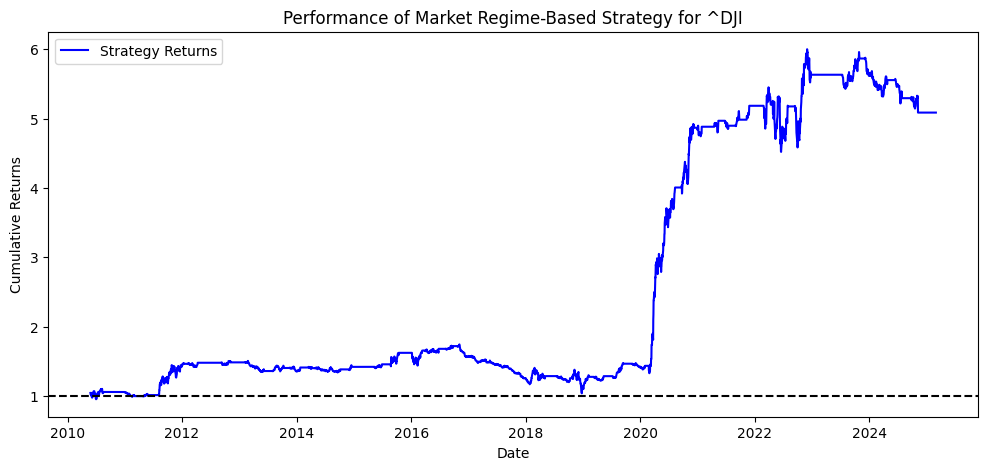

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ AI Index (ROBO) ===



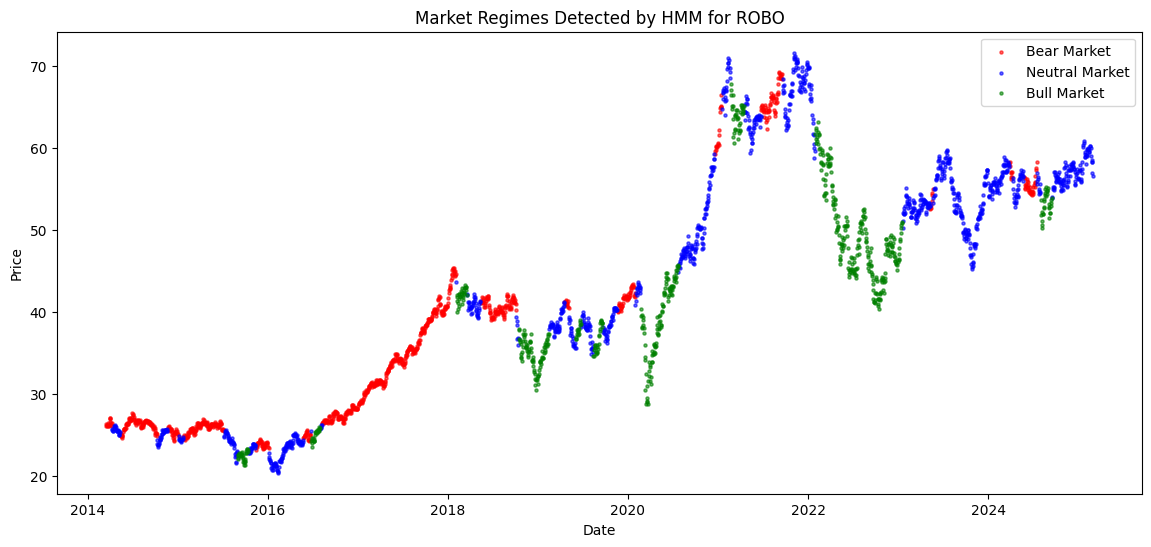

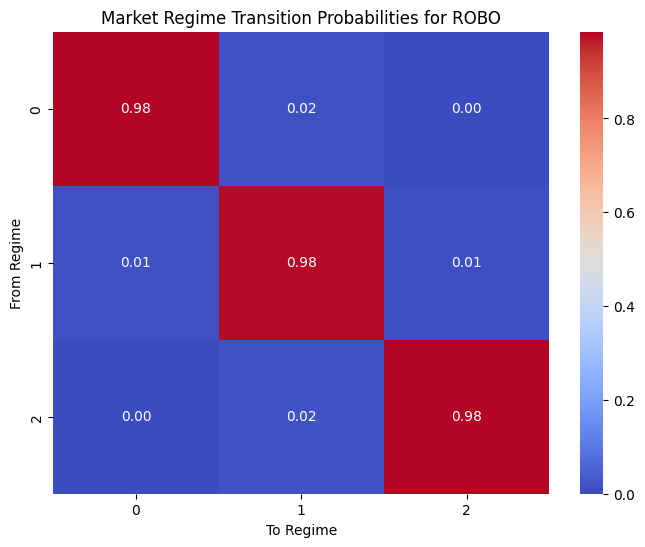

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


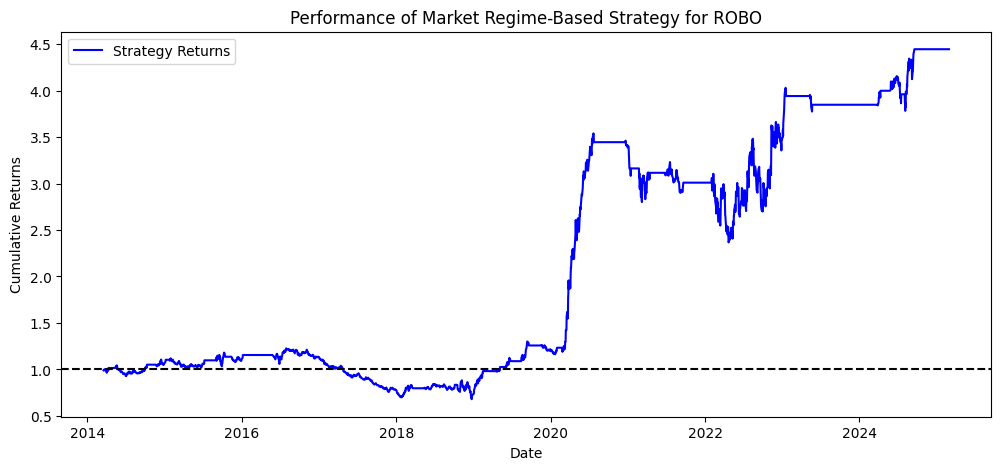

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Semiconductor (^SOX) ===



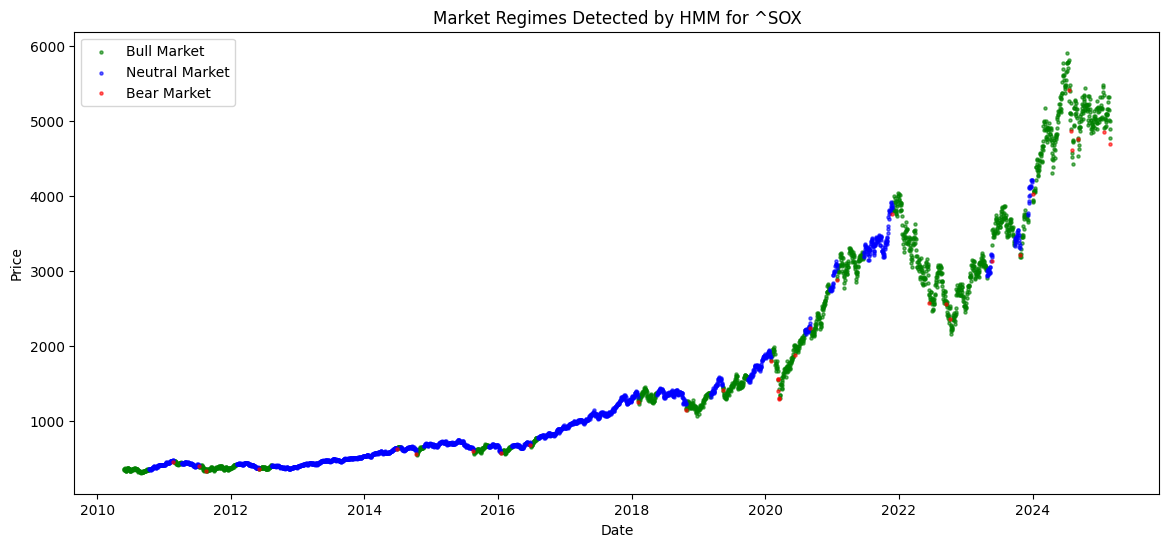

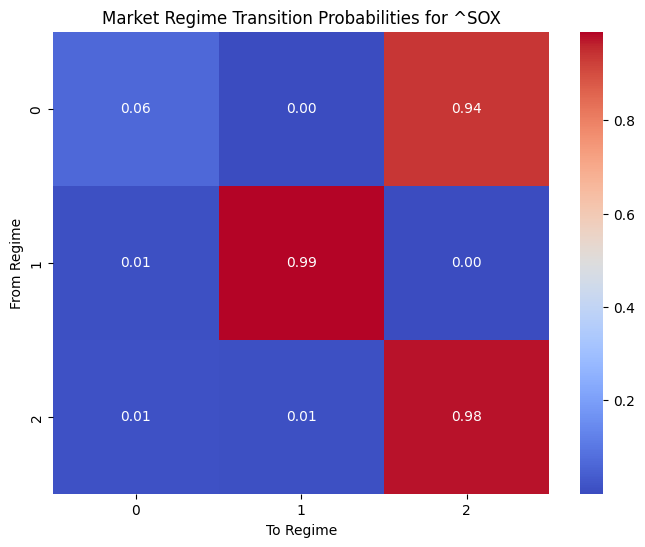

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


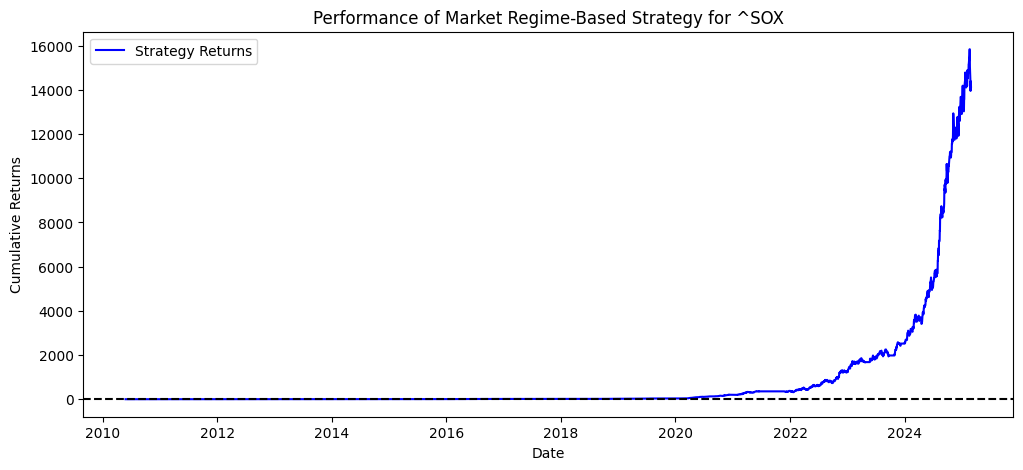

[*********************100%***********************]  1 of 1 completed


=== Running Market Regime Detection for NASDAQ Quantum Computing Index (QTUM) ===



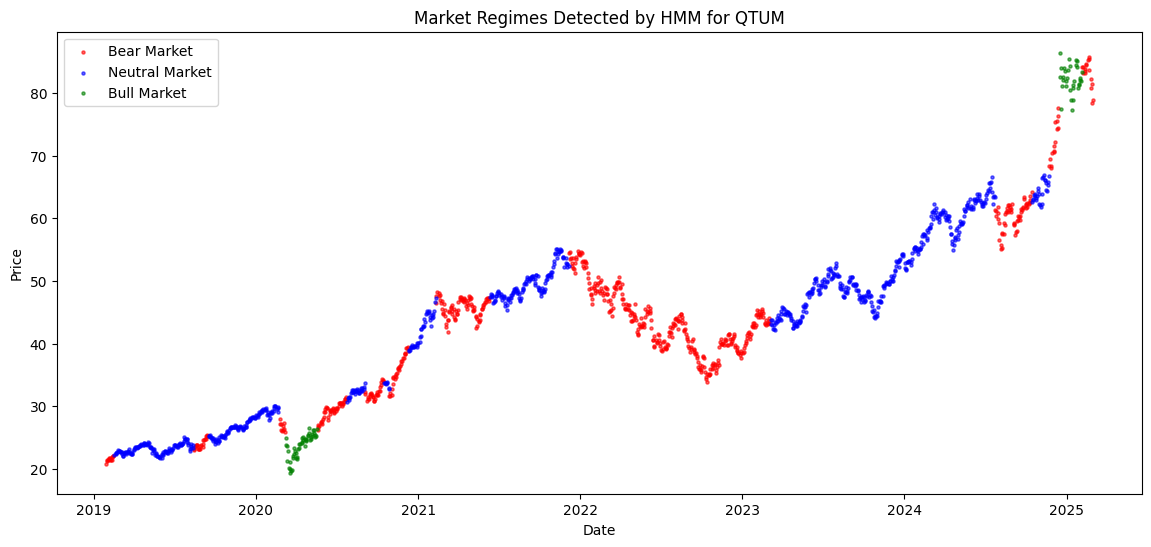

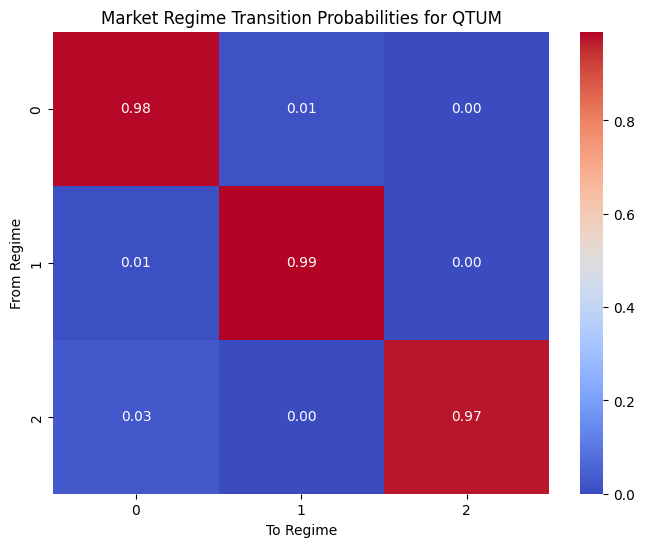

<ipython-input-32-e5da3cfbc3a6>:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull → Go Long with Leverage


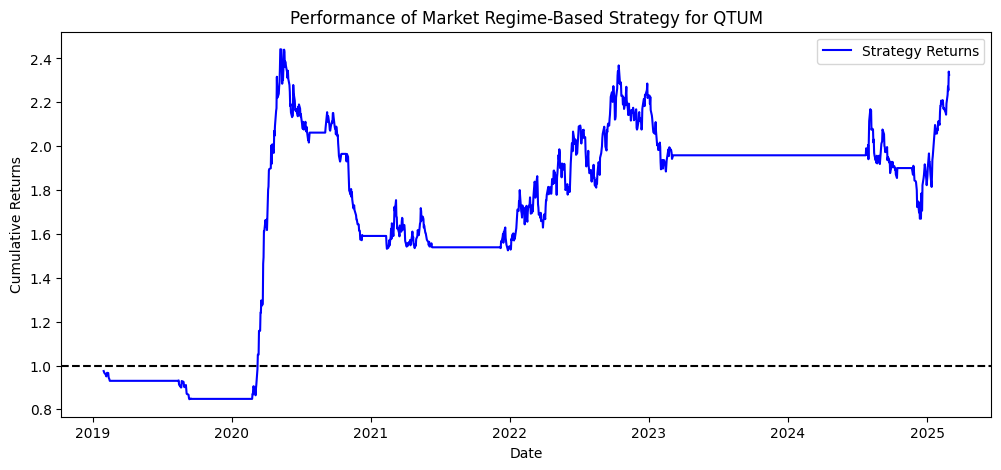

In [33]:
# List of major market indices with corrected tickers
indices = {
    "S&P 500 ETF": "SPY",
    "NASDAQ 100": "QQQ",
    "NASDAQ Composite": "^IXIC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ AI Index": "ROBO",
    "NASDAQ Semiconductor": "^SOX",
    "NASDAQ Quantum Computing Index": "QTUM"
}

# Run the analysis for each index
for name, ticker in indices.items():
    print(f"\n=== Running Market Regime Detection for {name} ({ticker}) ===\n")

    model = MarketRegimeHMM(ticker)
    model.fetch_data()
    model.train_hmm()
    model.visualize_market_regimes()
    model.plot_transition_probabilities()
    model.backtest_strategy()

# Deploying Risk-Managed Strategy Using Broker API (Alpaca, Interactive Brokers, Binance)
Now extend our Market Regime Detection Strategy and integrate it with real-time trading via broker APIs.
This allows us to execute trades automatically based on market regimes detected by Hidden Markov Models (HMMs).

✅ Uses Live Market Data – Fetches real-time stock prices from Alpaca, Interactive Brokers, or Binance.  
✅ Executes Trades Automatically – Places orders based on detected market regimes.  
✅ Risk-Managed Strategy – Includes stop-loss & leverage scaling.  


## Install broker APIs
For this example, we will use **Alpaca API** for stock trading.

In [34]:
!pip install alpaca-trade-api

## Update MarketRegimeHMM Class to Support Live Trading

In [35]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import alpaca_trade_api as tradeapi  # Broker API

class MarketRegimeHMM:
    def __init__(self, ticker, start_date="2010-01-01", end_date="2025-03-01", n_states=3, alpaca_api_key=None, alpaca_secret_key=None):
        """
        Initialize with the stock/index ticker, date range, and number of HMM states.
        If API keys are provided, enables live trading with Alpaca.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.hmm = None
        self.features_scaled = None

        # Alpaca API setup
        if alpaca_api_key and alpaca_secret_key:
            self.alpaca_api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, base_url="https://paper-api.alpaca.markets")
        else:
            self.alpaca_api = None  # Live trading disabled

    def fetch_data(self):
        """
        Fetch historical market data from Yahoo Finance.
        """
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        df["Returns"] = df["Close"].pct_change()
        df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
        df["Volatility"] = df["Log Returns"].rolling(window=30).std()
        df["Momentum"] = df["Close"] - df["Close"].shift(10)
        df["MA_30"] = df["Close"].rolling(window=30).mean()
        df["MA_100"] = df["Close"].rolling(window=100).mean()
        self.df = df.dropna()
        return self.df

    def train_hmm(self):
        """
        Train a Gaussian Hidden Markov Model (HMM).
        """
        features = self.df[["Log Returns", "Volatility"]].values
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(features)

        self.hmm = GaussianHMM(n_components=self.n_states, covariance_type="full", n_iter=200)
        self.hmm.fit(self.features_scaled)

        self.df["Regime"] = self.hmm.predict(self.features_scaled)

    def visualize_market_regimes(self):
        """
        Visualize Market Regimes on the stock price with Blue for Sideways Market.
        """
        plt.figure(figsize=(14, 6))
        colors = ["red", "blue", "green"]
        regime_names = ["Bear Market", "Sideways Market", "Bull Market"]

        for i, regime in enumerate(self.df["Regime"].unique()):
            plt.scatter(self.df.index[self.df["Regime"] == regime],
                        self.df["Close"][self.df["Regime"] == regime],
                        label=regime_names[regime],
                        color=colors[regime],
                        alpha=0.6, s=5)

        plt.title(f"Market Regimes Detected by HMM for {self.ticker}")
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.show()

    def execute_trade(self, position):
        """
        Places trade orders based on detected market regime.
        - "BUY" for Bull Market
        - "SELL" for Bear Market
        - "EXIT" for Sideways Market
        """
        if self.alpaca_api:
            try:
                if position == "BUY":
                    self.alpaca_api.submit_order(symbol=self.ticker, qty=10, side="buy", type="market", time_in_force="gtc")
                    print(f"✅ Executed BUY order for {self.ticker}")

                elif position == "SELL":
                    self.alpaca_api.submit_order(symbol=self.ticker, qty=10, side="sell", type="market", time_in_force="gtc")
                    print(f"✅ Executed SELL order for {self.ticker}")

                elif position == "EXIT":
                    print(f"🔹 No trade executed for {self.ticker} (Sideways Market)")

            except Exception as e:
                print(f"⚠️ Error executing trade: {e}")

    def live_trading(self, stop_loss_threshold=0.05, leverage_factor=1.5):
        """
        Execute trades in real-time based on detected regimes.
        """
        latest_data = self.fetch_data()
        latest_log_return = latest_data["Log Returns"].iloc[-1]
        latest_volatility = latest_data["Volatility"].iloc[-1]

        # Predict current market regime
        current_regime = self.hmm.predict([[latest_log_return, latest_volatility]])[0]

        # Determine trade action
        if current_regime == 2:  # Bull Market
            position = "BUY"
        elif current_regime == 0:  # Bear Market
            position = "SELL"
        else:  # Sideways Market
            position = "EXIT"

        # Execute trade based on prediction
        self.execute_trade(position)


## Run Live Trading for Multiple Indices

[*********************100%***********************]  1 of 1 completed


=== Running Live Trading for S&P 500 ETF (SPY) ===



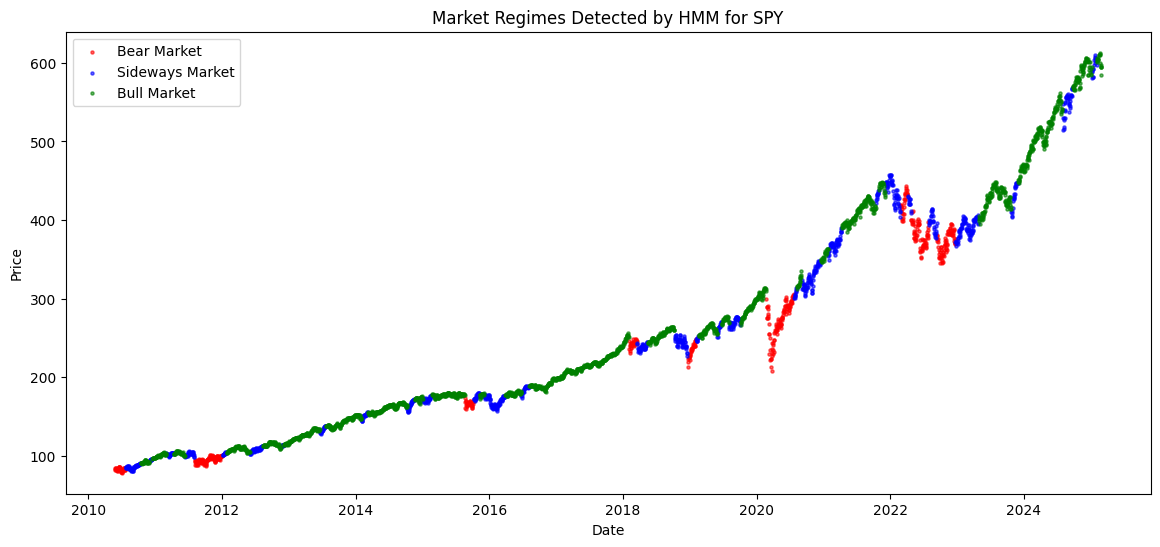

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ Error executing trade: forbidden.

=== Running Live Trading for NASDAQ 100 (QQQ) ===



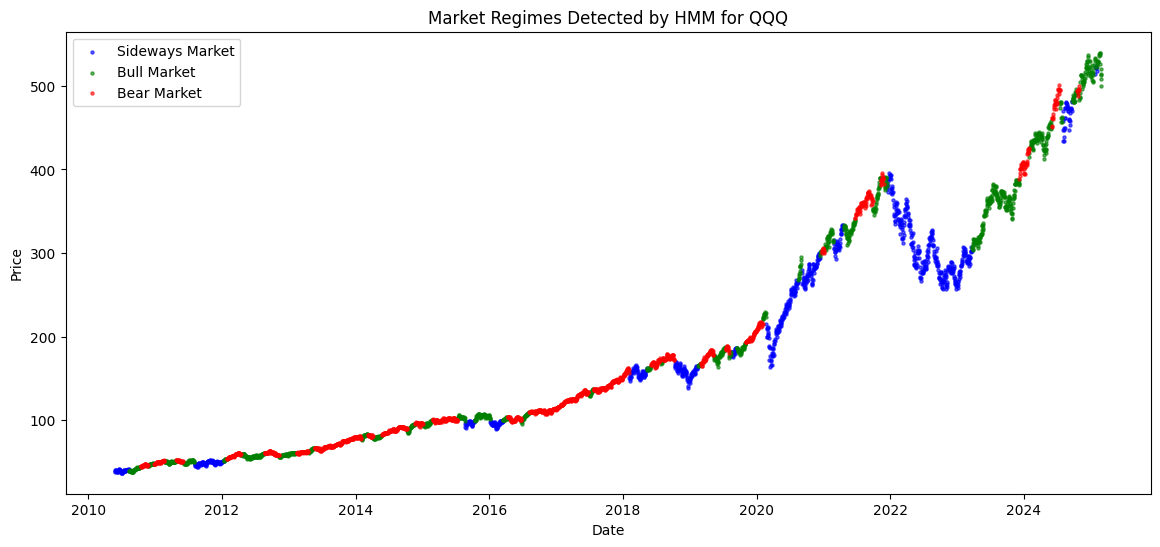

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


🔹 No trade executed for QQQ (Sideways Market)

=== Running Live Trading for NASDAQ Composite (^IXIC) ===



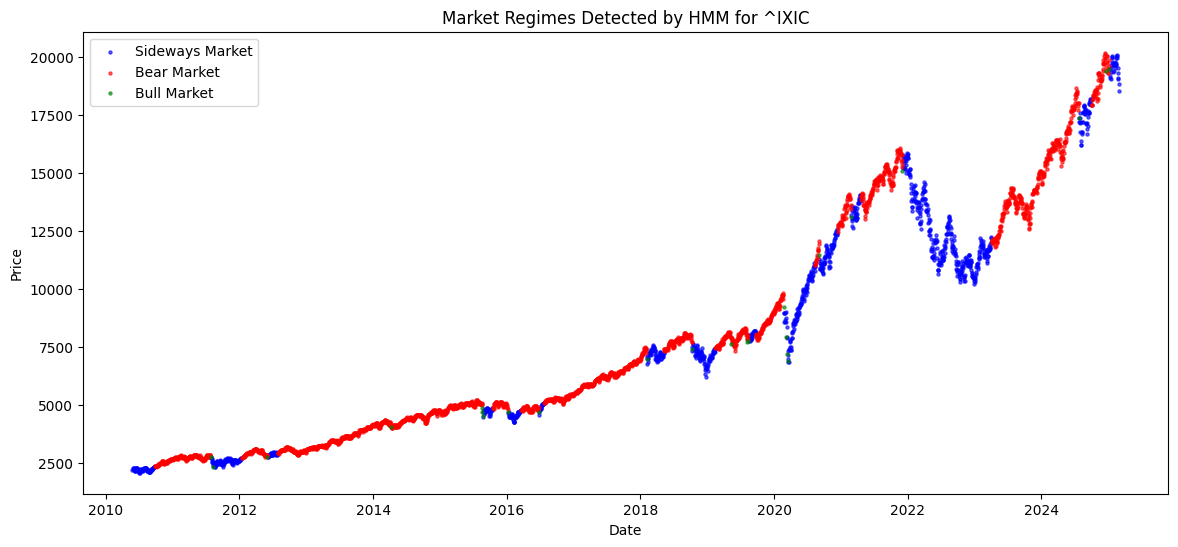

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


🔹 No trade executed for ^IXIC (Sideways Market)

=== Running Live Trading for Dow Jones Industrial Average (^DJI) ===



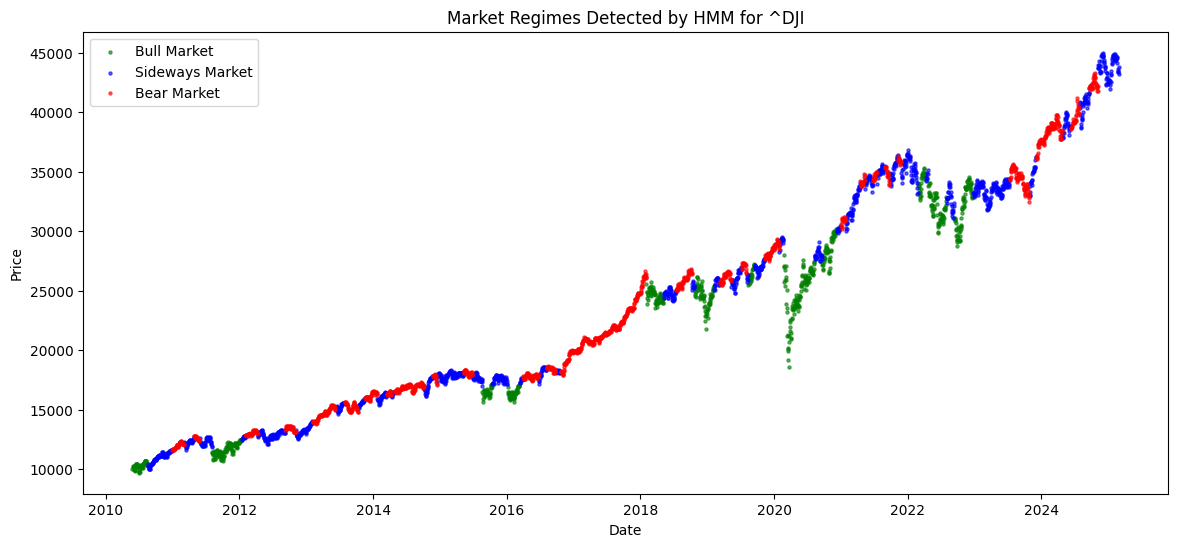

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ Error executing trade: forbidden.

=== Running Live Trading for NASDAQ AI Index (ROBO) ===



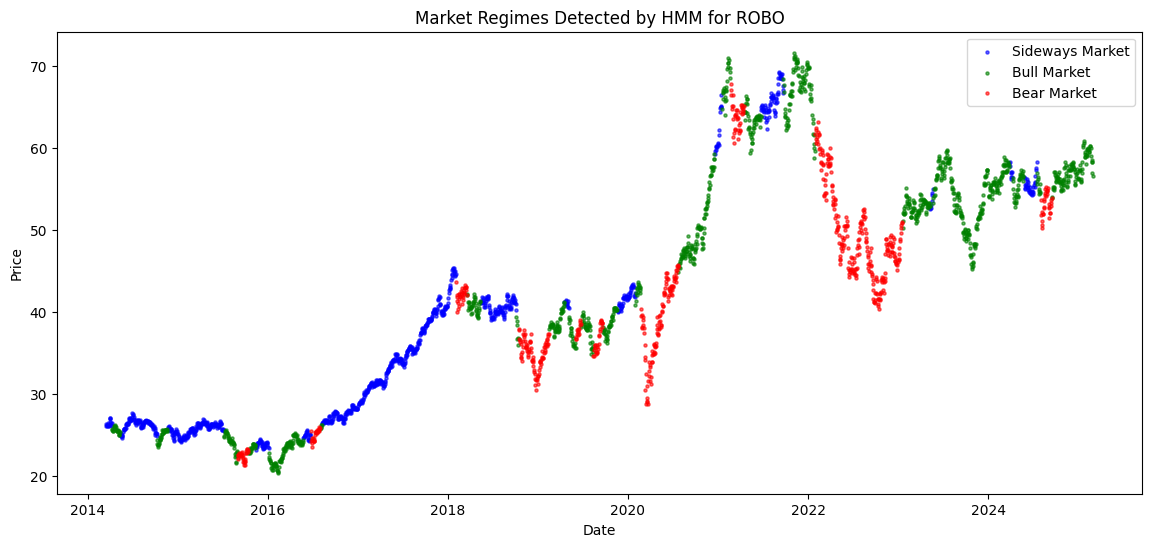

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


🔹 No trade executed for ROBO (Sideways Market)

=== Running Live Trading for NASDAQ Semiconductor (^SOX) ===



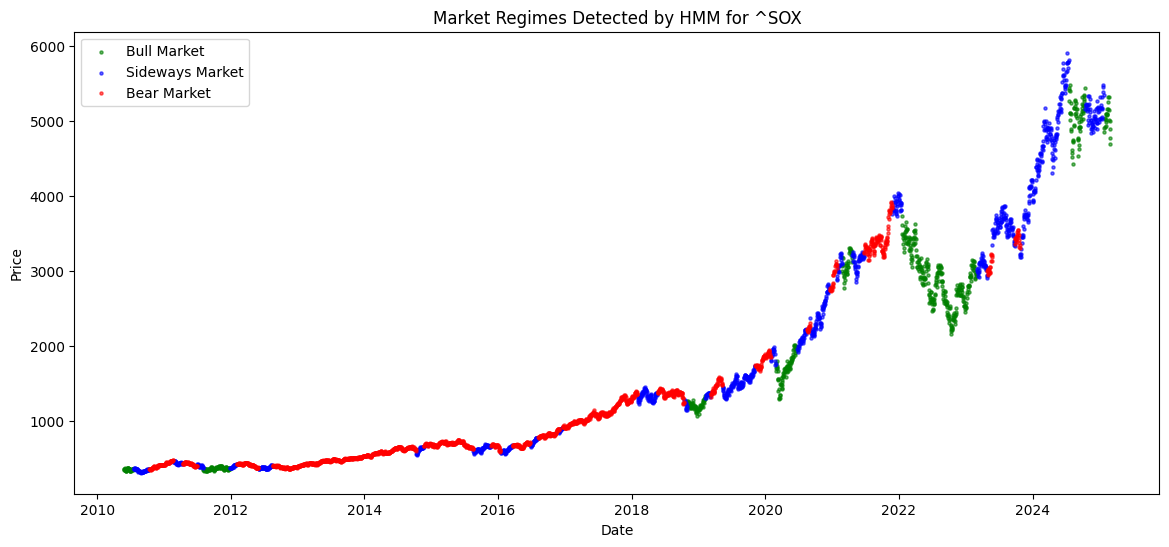

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


⚠️ Error executing trade: forbidden.

=== Running Live Trading for NASDAQ Quantum Computing Index (QTUM) ===



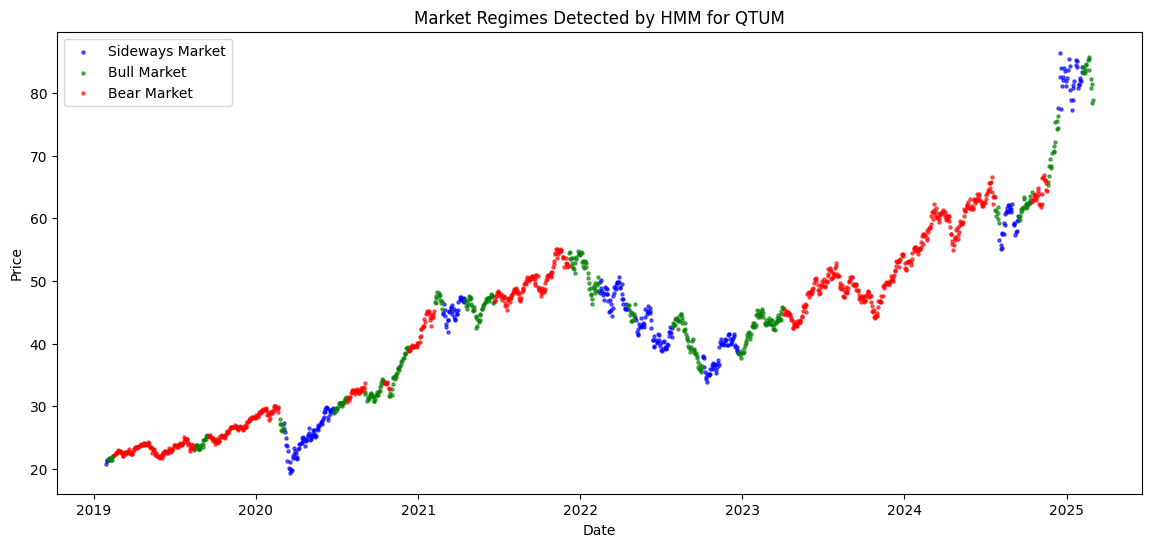

[*********************100%***********************]  1 of 1 completed

🔹 No trade executed for QTUM (Sideways Market)


In [36]:
# List of major market indices with correct tickers
indices = {
    "S&P 500 ETF": "SPY",
    "NASDAQ 100": "QQQ",
    "NASDAQ Composite": "^IXIC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ AI Index": "ROBO",
    "NASDAQ Semiconductor": "^SOX",
    "NASDAQ Quantum Computing Index": "QTUM"
}

# Alpaca API Keys (replace with your own)
ALPACA_API_KEY = "your_alpaca_api_key"
ALPACA_SECRET_KEY = "your_alpaca_secret_key"

# Run live trading for each index
for name, ticker in indices.items():
    print(f"\n=== Running Live Trading for {name} ({ticker}) ===\n")

    model = MarketRegimeHMM(ticker, alpaca_api_key=ALPACA_API_KEY, alpaca_secret_key=ALPACA_SECRET_KEY)
    model.fetch_data()
    model.train_hmm()
    model.visualize_market_regimes()
    model.live_trading()

# Backtest Performance Metrics (Sharpe Ratio, Drawdown, P&L Analysis)
Extend our Market Regime Detection strategy to include performance evaluation metrics such as: ✅ Sharpe Ratio – Measures risk-adjusted returns.  
✅ Max Drawdown – Quantifies the worst loss from peak to trough.  
✅ Cumulative P&L – Tracks total profit/loss over time.  
✅ Win Rate – Percentage of profitable trades.  
✅ Store Results in a Dictionary – Structured for multiple assets.  
✅ Print Performance Metrics in Table Format – For easy comparison.  

## Modify HMM the Class to Compute Performance Metrics

In [37]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from tabulate import tabulate  # For printing tables

class MarketRegimeHMM:
    def __init__(self, ticker, start_date="2010-01-01", end_date="2025-03-01", n_states=3):
        """
        Initialize with stock/index ticker, date range, and HMM states.
        """
        self.ticker = ticker
        self.start_date = start_date
        self.end_date = end_date
        self.n_states = n_states
        self.df = None
        self.hmm = None
        self.features_scaled = None
        self.performance_metrics = {}

    def fetch_data(self):
        """
        Fetch historical market data from Yahoo Finance.
        """
        df = yf.download(self.ticker, start=self.start_date, end=self.end_date)
        df["Returns"] = df["Close"].pct_change()
        df["Log Returns"] = np.log(df["Close"] / df["Close"].shift(1))
        df["Volatility"] = df["Log Returns"].rolling(window=30).std()
        df["Momentum"] = df["Close"] - df["Close"].shift(10)
        df["MA_30"] = df["Close"].rolling(window=30).mean()
        df["MA_100"] = df["Close"].rolling(window=100).mean()
        self.df = df.dropna()
        return self.df

    def train_hmm(self):
        """
        Train a Gaussian Hidden Markov Model (HMM).
        """
        features = self.df[["Log Returns", "Volatility"]].values
        scaler = StandardScaler()
        self.features_scaled = scaler.fit_transform(features)

        self.hmm = GaussianHMM(n_components=self.n_states, covariance_type="full", n_iter=200)
        self.hmm.fit(self.features_scaled)

        self.df["Regime"] = self.hmm.predict(self.features_scaled)

    def backtest_strategy(self, stop_loss_threshold=0.05, leverage_factor=1.5):
        """
        Backtest strategy and compute performance metrics.
        """
        self.df["Strategy"] = 0
        self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
        self.df.loc[self.df["Regime"] == 0, "Strategy"] = -1  # Bear Market → Short

        self.df["Strategy Returns"] = self.df["Strategy"].shift(1) * self.df["Log Returns"]
        self.df["Strategy Returns"] = np.where(self.df["Strategy Returns"] < -stop_loss_threshold, 0, self.df["Strategy Returns"])
        self.df["Cumulative Returns"] = (1 + self.df["Strategy Returns"]).cumprod()

        # Compute Performance Metrics
        sharpe_ratio = self.compute_sharpe_ratio(self.df["Strategy Returns"])
        max_drawdown = self.compute_max_drawdown(self.df["Cumulative Returns"])
        total_return = self.df["Cumulative Returns"].iloc[-1] - 1
        win_rate = self.compute_win_rate(self.df["Strategy Returns"])

        # Store in Dictionary
        self.performance_metrics = {
            "Ticker": self.ticker,
            "Sharpe Ratio": round(sharpe_ratio, 3),
            "Max Drawdown (%)": round(max_drawdown * 100, 2),
            "Total Return (%)": round(total_return * 100, 2),
            "Win Rate (%)": round(win_rate * 100, 2)
        }

        return self.performance_metrics

    def compute_sharpe_ratio(self, returns, risk_free_rate=0.01):
        """
        Compute Sharpe Ratio.
        """
        excess_returns = returns - risk_free_rate / 252
        return excess_returns.mean() / (excess_returns.std() + 1e-6) * np.sqrt(252)

    def compute_max_drawdown(self, cumulative_returns):
        """
        Compute Maximum Drawdown.
        """
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        return drawdown.min()

    def compute_win_rate(self, returns):
        """
        Compute Win Rate (percentage of positive return days).
        """
        wins = (returns > 0).sum()
        total_trades = len(returns.dropna())
        return wins / total_trades if total_trades > 0 else 0

    def plot_cumulative_returns(self):
        """
        Plot cumulative returns of the strategy.
        """
        plt.figure(figsize=(12, 5))
        plt.plot(self.df.index, self.df["Cumulative Returns"], label="Strategy Returns", color="blue")
        plt.axhline(1, linestyle="--", color="black")
        plt.legend()
        plt.xlabel("Date")
        plt.ylabel("Cumulative Returns")
        plt.title(f"Performance of Market Regime-Based Strategy for {self.ticker}")
        plt.show()

## Run Backtest for Multiple Indices & Print Results in Table

In [38]:
# List of major market indices
indices = {
    "S&P 500 ETF": "SPY",
    "NASDAQ 100": "QQQ",
    "NASDAQ Composite": "^IXIC",
    "Dow Jones Industrial Average": "^DJI",
    "NASDAQ AI Index": "ROBO",
    "NASDAQ Semiconductor": "^SOX",
    "NASDAQ Quantum Computing Index": "QTUM"
}

# Run the analysis and store performance metrics
results = []
for name, ticker in indices.items():
    print(f"\n=== Running Market Regime Detection for {name} ({ticker}) ===\n")

    model = MarketRegimeHMM(ticker)
    model.fetch_data()
    model.train_hmm()
    metrics = model.backtest_strategy()
    results.append(metrics)

# Convert results to table format
print("\n=== Performance Metrics for All ETFs/Stocks ===\n")
print(tabulate(results, headers="keys", tablefmt="grid"))


=== Running Market Regime Detection for S&P 500 ETF (SPY) ===



[*********************100%***********************]  1 of 1 completed
<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for NASDAQ 100 (QQQ) ===



<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for NASDAQ Composite (^IXIC) ===



<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for Dow Jones Industrial Average (^DJI) ===



<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for NASDAQ AI Index (ROBO) ===



<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for NASDAQ Semiconductor (^SOX) ===



<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
[*********************100%***********************]  1 of 1 completed



=== Running Market Regime Detection for NASDAQ Quantum Computing Index (QTUM) ===


=== Performance Metrics for All ETFs/Stocks ===

+----------+----------------+--------------------+--------------------+----------------+
| Ticker   |   Sharpe Ratio |   Max Drawdown (%) |   Total Return (%) |   Win Rate (%) |
+==========+================+====================+====================+================+
| SPY      |          0.301 |             -30.2  |              94.2  |          31.75 |
+----------+----------------+--------------------+--------------------+----------------+
| QQQ      |          0.575 |             -41.42 |             448.94 |          29.22 |
+----------+----------------+--------------------+--------------------+----------------+
| ^IXIC    |          0.753 |             -33.53 |             820.59 |          31.21 |
+----------+----------------+--------------------+--------------------+----------------+
| ^DJI     |         -0.166 |             -44.8  |             -2

<ipython-input-37-3a23b67da99b>:56: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  self.df.loc[self.df["Regime"] == 2, "Strategy"] = leverage_factor  # Bull Market → Leverage Long
